In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import scipy.stats as stat
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel
from bisect import bisect
from matplotlib.cm import get_cmap
from matplotlib.colors import PowerNorm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
import warnings

<h2> Load data </h2>

We start from loading the dataset after data imputation:

In [2]:
#load data
house_df = pd.read_csv('data/house_mean_imputation.csv')
#house_df = pd.read_csv('data/house_model_imputation.csv')
house_df = house_df.drop_duplicates(['year', 'state', 'district', 'name'])
display(house_df.shape)
display(house_df.head())
display(house_df.describe())

(9974, 20)

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
0,District 1,0.0,Ratliff Boon,D,42.1,Indiana,4281.0,1,1824,1824.0,0,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
1,District 1,1.0,Ratliff Boon,D,42.8,Indiana,5202.0,1,1826,1824.0,1,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
2,District 1,1.0,Ratliff Boon,D,52.2,Indiana,7272.0,1,1828,1824.0,2,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
3,District 1,0.0,John Law,D,49.1,Indiana,10868.0,0,1830,1860.0,0,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
4,District 1,1.0,Ratliff Boon,D,50.9,Indiana,11280.0,1,1830,1824.0,3,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375


,is_incumbent,percent,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,fundraising
count,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9.974000e+03
mean,0.444456,50.968786,101123.196765,0.528474,1991.993884,1102.728093,0.963305,6.176784,0.481251,0.604071,0.493377,219.603971,210.664830,1.014975e+06
std,0.496930,19.917918,55100.387633,0.499214,31.278231,987.884433,1.826929,2.060743,0.499673,0.489074,0.062378,36.152015,34.645436,9.782140e+05
min,0.000000,0.000000,0.000000,0.000000,1824.000000,0.000000,0.000000,2.700000,0.000000,0.000000,0.395000,38.000000,86.000000,-3.469651e+04
25%,0.000000,36.160000,59347.250000,0.000000,1982.000000,0.000000,0.000000,4.600000,0.000000,0.000000,0.480000,194.000000,180.000000,5.015548e+05
50%,0.000000,50.235000,94682.000000,1.000000,2004.000000,1938.000000,0.000000,5.790931,0.000000,1.000000,0.490000,205.000000,225.000000,8.306668e+05
75%,1.000000,64.300000,136625.250000,1.000000,2012.000000,2002.000000,1.000000,7.000000,1.000000,1.000000,0.528000,248.000000,241.000000,1.329461e+06
max,1.000000,100.000000,322514.000000,1.000000,2018.000000,2018.000000,17.000000,19.000000,1.000000,1.000000,0.701000,334.000000,303.000000,3.410465e+07


We have some data where the president party is not defined: typically they're data from non-election years. Let's drop them.

In [3]:
#drop observations where president party is not defined
house_df=house_df.drop(house_df.loc[house_df['president_party']=="0"].index)

<h2> Baseline model </h2>

We define our baseline model simply taking the party, per each district, with the highest winning rate.

Here we have defined `winnerFilter_` and `baselineTrain_`. The only difference with the `winnerFilter` and `baselineTrain` defined in 02-EDA phase is that here we refer to parties as 1 and 0, instead than as 'R' and 'D'

We prepare a dictionary `results` containing the winner parties of each year, grouped by state and district 

Also, we define `districtPredictions` and `districtAccuracy` that merge predictions with actual districts, so that accuracy is calculated on all existing districts, rather than only on the ones for which we have a predicted winner. 

In fact:
- based on the training set we might not have a prediction for all districts. As districts are redistributed through the years, one that is in the test set might not exist in the training set, so we have no prediction for it.
- we might have ex aequo winning predictions among candidates of opponent party, which do not lead to a winner prediction

In [4]:
#baseline model
def winnerFilter_(df):
    return df[df['won']==1][['state','district','party']].replace(['D', 'R'], [0, 1])

def baselineTrain_(df):
    df_grouped=df[(df['won']==1)].groupby(['state', 'district'])['party'].sum().reset_index(drop=False)
    df_grouped['R_occurence']=df_grouped['party'].str.count('R')/df_grouped['party'].str.len()
    df_grouped['party']=(df_grouped['R_occurence']>0.5).astype(int)
    df_grouped['proba']=(1-df_grouped['party']-df_grouped['R_occurence']).abs()
    return df_grouped[['state', 'district','party', 'proba']]

#prepare dataset indexed by state and district, with all results 
results=dict()
for year in house_df['year'].unique():
    results[year]=house_df[house_df['year']==year].groupby(['state', 'district']).count()
    results[year]=results[year].drop(columns = list(results[year]))    
    results[year]['partyWon']=winnerFilter_(house_df[house_df['year']==year]).set_index(['state','district']).sort_index()
def districtPredictions(y_pred, year, partyWonCol='party', set_index=1):
    if set_index:
        df=results[year].join(y_pred.set_index(['state', 'district'])).sort_index().fillna(-1)
    else:
        df=results[year].join(y_pred).fillna(-1)
    return df
def districtAccuracy(y_pred, year, partyWonCol='party', set_index=1):
    df=districtPredictions(y_pred, year, partyWonCol, set_index)
    return sum(df['partyWon']==df[partyWonCol])/len(df)

Using the above functions, we calculate the accuracy of the baseline model over the 2018 test set:

In [5]:
y_pred=baselineTrain_(house_df[house_df['year']!=2018]) #train simple average model, remove 2018 results
baseline_accuracy=districtAccuracy(y_pred, 2018)
print('Baseline 2018 test accuracy: \t{:.2%}'.format(baseline_accuracy))

Baseline 2018 test accuracy: 	76.78%


<h2> Functions definitions </h2>

We define a function `splitDf` for splitting the dataset:
- test set on data belonging to a specified input `year`
- training set on data from remaining years
- store `state`, `district` and `party` information using the same original index as the main data
- drop response features like `percent` and `votes`, plus `state`, `district` and `name`
- split into `x_train` and `y_train`, `x_test` and `y_test`, using `won` as response feature
- return `x_train`, `y_train`, `x_test`, `y_test`, `indexed_districts` and `indexed_party`

In [6]:
def splitDf(df, year):
    dfcopy=df.dropna().copy()
    indexed_districts=dfcopy[['state','district']]
    indexed_party=dfcopy[['party']].replace(['D', 'R'], [0, 1])
    dfcopy=dfcopy.drop(columns=['state', 'district', 'name', 'percent', 'votes'])
    data_train, data_test=dfcopy[dfcopy['year']!=year], dfcopy[dfcopy['year']==year]
    #data_train, data_test=dfcopy[dfcopy['year']<year], dfcopy[dfcopy['year']==year]

    x_train, y_train=data_train.drop('won', axis=1), data_train['won']
    x_test, y_test=data_test.drop('won', axis=1), data_test['won']
    return x_train, y_train, x_test, y_test, indexed_districts, indexed_party

<h3> Plots </h3>

Here we define several plotting functions which will be used afterwards:

In [7]:
#plot cross validation scores of decision trees
def plotCVscores(depths, scores_train, scores_train_CV, scores_train_CVstd, title, xlabel='Depth'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=24, y=1.0)
    ax.plot(depths, scores_train, label = 'Full training set')
    ax.plot(depths, scores_train_CV, label = 'Cross validation means')
    upper=np.array(scores_train_CV)+2*np.array(scores_train_CVstd)
    lower=np.array(scores_train_CV)-2*np.array(scores_train_CVstd)
    ax.fill_between(depths, lower, upper, color='chocolate', alpha='0.1')
    ax.axhline(y=1, c='g', label='100% accuracy')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Score')
    #ax.set(ylim=([0.95*min(lower),1.05*max(upper)])) #I guess this is the meaning of "set the y-axis to focus on the cross-validation performance."
    ax.set_xticks(depths)
    ax.legend();
#plot scores of a model through years
def plotYearscores(years, scores_train, scores_train_CV, scores_CV_mutExcl, Accu_val_2_byDistrict, title, xlabel='Year'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=24, y=1.0)
    ax.plot(years, scores_train, label = 'training set')
    ax.plot(years, scores_train_CV, label = 'validation score')
    ax.plot(years, scores_CV_mutExcl, label = 'validation mutually exclusive score')
    ax.plot(years, Accu_val_2_byDistrict, label = 'validation mutually exclusive score by district')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Score')
    ax.set_xticks(years)
    ax.legend();
#bar plot with model scores
def barplotScores(models_names, scores_train, scores_val, scores_val_mut_escl, scores_val_mut_escl_byDistrict, baseline_accuracy):
    #plot
    from matplotlib.ticker import PercentFormatter
    
    fontsize=13
    current_palette = sns.color_palette()
    fig, ax = plt.subplots(1, 1, figsize=(15, 2*len(models_names)))
    fig.suptitle('Scores of all fitted models on training vs cross-validation means', fontsize=24, y=0.98) 
    w=0.2
    a=np.arange(len(models_names))
    ax.barh(a+1.5*w, scores_train, height=w,align='center', color=current_palette[0], alpha=0.5, label='train set') 
    ax.barh(a+0.5*w, scores_val, height=w,align='center', color=current_palette[1], alpha=0.5, label='CV set')   
    ax.barh(a-0.5*w, scores_val_mut_escl, height=w,align='center', color=current_palette[2], alpha=0.5, label='CV set mut. excl.')  
    ax.barh(a-1.5*w, scores_val_mut_escl_byDistrict, height=w,align='center', color=current_palette[3], alpha=0.5, label='CV set mut. excl. by district')  
    
    for i, v in enumerate(scores_train):
        ax.text(v-0.02, i+1.5*w, '{:>.2%}'.format(v), color='white', fontsize=fontsize, verticalalignment='center')
        ax.text(scores_val[i]-0.02, i+0.5*w, '{:>.2%}'.format(scores_val[i]), color='white', fontsize=fontsize, verticalalignment='center')
        ax.text(scores_val_mut_escl[i]-0.02, i-0.5*w, '{:>.2%}'.format(scores_val_mut_escl[i]), color='white', fontsize=fontsize, verticalalignment='center')
        ax.text(scores_val_mut_escl_byDistrict[i]-0.02, i-1.5*w, '{:>.2%}'.format(scores_val_mut_escl_byDistrict[i]), color='white', fontsize=fontsize, verticalalignment='center')
  
    ax.axvline(x=baseline_accuracy, c='g', label='baseline')
    ax.text(baseline_accuracy, -0.8, '{:.2%}'.format(baseline_accuracy), color='green', horizontalalignment='center', verticalalignment='center', fontsize=fontsize)

    #ax.xaxis.set_major_formatter(PercentFormatter())
    #ax.set_xticklabels(fontsize=fontsize)
    ax.set_xlabel('Score', fontsize=fontsize)
    ax.set_yticklabels(models_names, fontdict=None, minor=False, fontsize=fontsize) 
    ax.set_yticks(a, minor=False)
    plt.xlim(baseline_accuracy*0.95,1)
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=fontsize)    
    ax.legend(fontsize=fontsize)
    #fig.legend(bbox_to_anchor=(1.45, 0.84), fontsize=fontsize); #put the legend outside the plot
def plotModelsScores(modelList, baseline_accuracy):
    models_names=[]
    scores_train=[] 
    scores_val=[] 
    scores_val_mut_escl=[]
    scores_stacking=[]
    scores_val_mut_escl_byDistrict=[]
    for model in modelList:
        models_names.append(model['name'])
        scores_train.append(model['score train'])
        scores_val.append(model['score validation'])
        scores_val_mut_escl.append(model['score val mut exclusive'])
        scores_val_mut_escl_byDistrict.append(model['score val mut exclusive by district']) 
    barplotScores(models_names, scores_train, scores_val, scores_val_mut_escl, scores_val_mut_escl_byDistrict, baseline_accuracy)
def plotDR(df, n_intervals=30, markersize=20, fontsize=12):
    pred2018=df.copy()
    breakpoints=(np.arange(0,1,1/n_intervals)+1/n_intervals).round(5)
    x_cols=(breakpoints-0.5/n_intervals).round(5)
    breakpoints=breakpoints[:-1]

    #function to assign an ID-interval x_cols according to which interval the input value lies within breakdowns
    def x_prob(proba):
        return x_cols[bisect(breakpoints, proba)]
    #assign a number from 0 to 1 according to the probability of democrat towards probability of republican
    pred2018['DtoRproba']=(1-pred2018['won_pred']-pred2018['rel_won_proba']).abs()
    #use x_prob to assign in which interval each observation lies
    pred2018['x']=pred2018['DtoRproba'].apply(x_prob) 
    #assign the y position in the scatterplot for each observation: for each x-position assign to each observation a growing number 
    for x_col in x_cols:
        pred2018.loc[pred2018['x']==x_col, 'y']=np.arange(sum(pred2018['x']==x_col))
    #Define color ID: according to prediction probability and correctness of prediction
    midColor=0.5 #color for 50% probability values: 0.0=completely white, 0.5=max
    pred2018['color_strength']=midColor*pred2018['rel_won_proba'].apply(x_prob)+midColor #probability is from 0.5 to 1, but we convert to a less steep line, for example 0.75 to 1
    pred2018['colorID']=(1-pred2018['won_pred']-pred2018['color_strength']).abs() #convert colorID from being >0.5, to be between 0 and 1 according to the party prediction
    pred2018['colorID']=(((~pred2018['correct_pred']).astype(float)-pred2018['colorID'])).abs() #switch to the opposite colorID if prediction was wrong
    #Define colors
    colorsDR=(['#0869ac', '#ffffff', '#d00d0f'])
    #Define linear color space
    line_cmap = LinearSegmentedColormap.from_list('my_cmap', colorsDR)
    line_norm = Normalize(vmin=0,vmax=1)
    #Assign color from color space according to color ID
    pred2018['color']=pred2018['colorID'].apply(line_cmap)
    fig, ax = plt.subplots(1, 1, figsize=(markersize*1.2/2, pred2018['y'].max()*markersize*1.2/200))
    fig.suptitle('2018 predictions vs actual results', fontsize=24, y=0.95)
    legend_elements = [plt.scatter([x_cols[0]], [0], marker='o', color=colorsDR[0], s=markersize, label='Democrats won'),
                       plt.scatter([x_cols[-1]], [0], marker='o', color=colorsDR[-1], s=markersize,label='Republicans won')]
    for color in pred2018['color'].unique():
        x=pred2018.loc[pred2018['color']==color, 'x']
        y=pred2018.loc[pred2018['color']==color, 'y']
        ax.scatter(x, y, color=color, s=markersize)
    ax.set_xlabel('\nD to R prediction probability', fontsize=fontsize)
    ax.set_ylabel('seats', fontsize=fontsize)
    x_ticks=np.arange(0,1.1,0.1)
    ax.set_xticks(x_ticks)
    x_tickslabels=['100% D', '90% D', '80% D', '70% D', '60% D', '50%', '60% R', '70% R', '80% R', '90% R', '100% R', ]
    #ax.set_xticklabels(['{:,.0%}'.format(x) for x in x_ticks])
    ax.set_xticklabels(x_tickslabels, fontsize=fontsize)
    #ax.set_xticks(pred2018['x'])
    ax.legend(handles=legend_elements, loc='upper center', shadow=True, fontsize=fontsize)
def barPlotFeatImp(df):
    feat_df=df[['mean', 'std']].sort_values(by=['mean'], ascending=True).copy()
    fig, ax = plt.subplots(1, 1, figsize=(8, len(feat_df)/3))
    fig.suptitle('Feature importance', fontsize=24, y=1) 
    ax.barh(feat_df.index, feat_df['mean'], alpha=0.5) 
    ax.set_xlabel('Score')
#plot staged scores on ax
def plotScoreVsIter(boost, X, y, ax, label='Train set, AdaBoost', linestyle='-', color='blue'):
    xticks=np.arange(1,len(boost.estimators_)+1)
    ax.plot(xticks, list(boost.staged_score(X,y)), linestyle, c=color, label = label)
#plot a list of models scores
def PlotAdaBoost3(modelList, X_train, y_train, X_test, y_test, title):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle(title, fontsize=24, y=1.0)
    colors=sns.color_palette('colorblind', len(modelList))
    for model, c in zip(modelList, colors):
        plotScoreVsIter(model['model'], X_train, y_train, ax, 'Train set, {}'.format(model['name']), '--', c)
        plotScoreVsIter(model['model'], X_test, y_test, ax, 'Test set, {}'.format(model['name']), color=c)
    ax.set_xlabel('number of iterations')
    ax.set_ylabel('Score')
    lgd = ax.legend(bbox_to_anchor=(1, 0.1), loc='lower left', borderaxespad=1);
    #fig.savefig('samplefigure', bbox_extra_artists=(lgd,), bbox_inches='tight') #to avoid cutoff legend
    #I choosed to use the same color for train and test sets and changing only the linestyle
    #It is more convenient when displaying more than one boosting model
    #As a future improvement I would split the legend in 2, one for colors and one for linestyle.

<h2> Feature engineering </h2>
<h3> Partisanship </h3>

`deductPartisanship`:
- for a given `x_train` set, we look at the prevalence of one party to win in each district, looking at the `y_train` data. 
- a district is partisan for a specific party, if the winning rate of that party in history is greater than 66.7%. (we assign 3=traditionally Republican, 2=traditionally Democrat)
- if no parties have a winning rate grater than 2/3 (66.7%), then that is a "swing district" (we assign 1)
- if we don't have enough historical data, because the district is new, we don't conclude anything (we assign 0)

Then with `assignPartisanship` we assign the 3,2,1 or 0 value for partisanship to each district in the `x_test` data, using the `deductPartisanship` function.

This is a model by itself, with a train step and a predict step. When using this feature into another model, we do a kind of stacking, in fact.

In [8]:
def deductPartisanship(trainData):
    #compute the prevalence of one party win against the other
    house_df_all_districts=trainData[(trainData['won']==1)].groupby(['state', 'district'])['party'].sum().reset_index(drop=False)
    house_df_all_districts['R_occurence']=house_df_all_districts['party'].str.count('R')/house_df_all_districts['party'].str.len()

    avgHistData=house_df_all_districts['party'].str.len().mean() #Average amount of historical data per district
    histDataThreshold=avgHistData/2

    #3=traditionally Republican district
    #2=traditionally Democrat district
    #1=swing district
    #0=Recent district (Not enough historical data)
    house_df_all_districts['partisanship']=(house_df_all_districts['party'].str.len()>=histDataThreshold)*(
                      (house_df_all_districts['R_occurence']>(2/3))*3
                    + (house_df_all_districts['R_occurence']<=(1/3))*2
                    + ((house_df_all_districts['R_occurence']>(1/3))
                      &(house_df_all_districts['R_occurence']<=(2/3)))*1
                    )
    house_df_all_districts['partisanship']=house_df_all_districts['partisanship'].astype(int)
    return house_df_all_districts[['state', 'district', 'partisanship']]

def assignPartisanship(x_train, y_train, indexed_districts, x_test):
    train_df=x_train.copy()
    train_df['won']=y_train
    train_df=indexed_districts.join(train_df).dropna()
    test_df=indexed_districts.join(x_test.copy()).dropna()

    out_df=test_df.join(deductPartisanship(train_df).set_index(['state', 'district']), on=['state', 'district']).drop('state', axis=1).drop('district', axis=1).fillna(0)
    out_df['partisanship']=out_df['partisanship'].astype(int)
    return out_df

<h3> Design features, drop features</h3>

In the `designFeatures` function we applied mathematical transformations, convert strings to numbers, produced an amount of interaction terms, fixed a bug in the `first_time_elected` feature. 

The partisanship function gives an indication in case a district is traditionally tied to a party rather than the other. 

All features referring to an absolute party (R or D) have been changed so that they relate to the candidate's party, instead. For example, the district partisanship (democrat or republican or none) is changed to district partisanship for candidate's party.

To decide which columns to drop, we looked at the feature importance of the logistic regression model.

In [9]:
def designFeatures(x_train, y_train, indexed_districts, df):
    df_out=df.copy()
    
    #first_time_elected relative to election year and non-negative
    df_out.loc[df_out['first_time_elected']>0, 'first_time_elected']=df_out['year']-df_out['first_time_elected']
    df_out.loc[df_out['first_time_elected']<0, 'first_time_elected']=0
    
    #Assign district partisanship
    df_out=assignPartisanship(x_train, y_train, indexed_districts, df_out)
    
    #calculate Log10 of fundraising
    df_out['Log10fundraising']=df_out['fundraising']
    df_out.loc[df_out['Log10fundraising']<=0, 'Log10fundraising']=np.NaN
    df_out['Log10fundraising']=np.log10(df_out['Log10fundraising']) #take the log10
    df_out.loc[df_out['Log10fundraising'].isna(), 'Log10fundraising']=0
    
    #president party is same party as candidate
    df_out['own_president_party']=(df_out['president_party']==df_out['party']).astype(int)
    df_out['own_last_house_majority']=(df_out['last_house_majority']==df_out['party']).astype(int)
    
    #replace 'D' and 'R' with 0 and 1 
    df_out['party']=df_out['party'].replace(['D', 'R'], [0, 1])
    df_out['president_party']=df_out['president_party'].replace(['D', 'R'], [0, 1])
    df_out['last_house_majority']=df_out['last_house_majority'].replace(['D', 'R'], [0, 1])
    
    #Is district partisan of the candidate's party?
    df_out['ownPartisan']=((df_out['partisanship'].astype(int))-df_out['party'].astype(int)==2).astype(int)
    df_out['swingDistrict']=(df_out['partisanship'].astype(int)==1).astype(int)
    df_out=pd.get_dummies(df_out, columns=['partisanship'], drop_first=True) #
    
    #Ratio of R vs D seats before election. Percentage of opponent seats in House 
    df_out['last_R_vs_D_Seats']=df_out['last_R_house_seats']/(df_out['last_R_house_seats']+df_out['last_D_house_seats']) #1=100% R, 0=100% D
    df_out=df_out.drop('last_R_house_seats', axis=1).drop('last_D_house_seats', axis=1)
    
    #Percentage of own party seats in House. Non-linear interaction term (because of abs)
    df_out['last_own_party_Seats']=(1-df_out['party']-df_out['last_R_vs_D_Seats']).abs() #1=100% own seats, 0=100% opponent
    
    #President job approval or opposition
    df_out['own_president_job_approval']=((df_out['own_president_party']).abs()*df_out['president_overall_avg_job_approval']).abs()
    df_out['president_opposition_job_approval']=((df_out['party']-df_out['president_party']).abs()*df_out['president_overall_avg_job_approval']).abs()
    
    #Own president unemployment rate or opposition
    df_out['unemployement_rate_own_president']=df_out['own_president_party']*df_out['unemployement_rate']
    df_out['unemployement_rate_president_opposition']=(df_out['party']-df_out['president_party']).abs()*df_out['unemployement_rate']
    return df_out

def drop_features(df):
    df_out=df.copy()
    
    #drop linear fundraising
    df_out=df_out.drop('fundraising', axis=1)
    
    #drop party-related features
    df_out=df_out.drop('last_R_vs_D_Seats', axis=1) #
    df_out=df_out.drop('president_party', axis=1) #
    #df_out=df_out.drop('party', axis=1)
    df_out=df_out.drop('last_house_majority', axis=1) #
    
    #drop president-related features, without specification for candidates party
    df_out=df_out.drop('president_can_be_re_elected', axis=1) #
    df_out=df_out.drop('president_overall_avg_job_approval', axis=1) #
    
    #drop low importance features
    df_out=df_out.drop('is_presidential_year', axis=1) #
    #df_out=df_out.drop('year', axis=1)
    #df_out=df_out.drop('own_president_party', axis=1) #
    if 'partisanship_1' in list(df_out): #check before dropping: districts which are 'swing' but did not exist in past years, can lead to the absence of 'partisanhip_1' column 
        df_out=df_out.drop('partisanship_1', axis=1)
    #df_out=df_out.drop('partisanship_2', axis=1)
    #df_out=df_out.drop('partisanship_3', axis=1)
    
    #drop collinear features
    df_out=df_out.drop('unemployement_rate', axis=1)
    #df_out=df_out.drop('first_time_elected', axis=1)
    #df_out=df_out.drop('count_victories', axis=1)
    #df_out=df_out.drop('is_incumbent', axis=1)
    
    return df_out

<h2> Functions for running predictions and compute accuracy </h2>
<h3> Mutual exclusive selection </h3>

The `MutuallyExclusivePredictions` function is used to tangibly increase the prediction accuracy, leveraging the fact that we need one winner per district:
- calculates score of the fitted input `model` on training and test set 
- perform a mutual exclusive win assignment
- return predictions and all three accuracy scores (train, test, test mutual exclusive)

About the mutual exclusive assignment, at that point we have a prediction per each candidate, but we don't check to have only one predicted winner per district, so we need to take only one winner per district:
- Group by district and assign win only to the candidate with highest win probability
- In case of more than one candidate with exact the same winning probability in the same district:
    - If those candidates belong to the same party, assign win only to the first one (in our scope we care about the winning party, not the candidate)
    - If those candidates belong to different parties, we can say nothing therefore we don't have a winner prediction for that district
- Calculate the accuracy score of the resulting predictions 
    - The accuracy score of the candidates predictions at this point, is affected by a little component of randomness, as in case of conflict between candidates of the same party, we take the first one. But that is lower or equal, not greater than the score having selected the "right" candidate when taking the first one. So we should not take it for comparison between models, rather to see that the score has increased from simple cross validation score
- The `MutuallyExclusivePredictions` function displays a detailed report during execution, which helps understanding the results. In case of more than one winner per district, it will prompt a warning, followed by the list of affected districts and all the details related to the first occurrence

In [10]:
def MutuallyExclusivePredictions(model, x_train, x_test, y_train, y_test, indexed_districts, indexed_party):
    #y_test is used only for accuracy score
    
    x_traincopy=x_train.copy()
    x_testcopy=x_test.copy()
    
    def Accuracy(y, y_pred):
        return np.sum(y == y_pred) / len(y)

    #predict results
    y_pred_train=model.predict(x_traincopy)
    y_pred_test=model.predict(x_testcopy)

    #calculate accuracy
    Accu_train=Accuracy(y_train, y_pred_train)
    Accu_val=Accuracy(y_test, y_pred_test)
    
    #At this stage, our predictions could lead to more than one winner per district (or none), but in reality they are mutually exclusive 
    #We will take the maximum prediction probabilities to be sure to have one and only one winner per district
    #predict probabilities
    #y_pred_train=model.predict_proba(x_traincopy)[:,1]
    y_pred_test=model.predict_proba(x_testcopy)[:,1]

    #Add index to predictions from X set
    #y_pred_train_df=pd.DataFrame(y_pred_train, index=x_traincopy.index, columns=['abs_won_proba'])
    y_pred_test_df=pd.DataFrame(y_pred_test, index=x_testcopy.index, columns=['abs_won_proba'])

    #Join party data to train and test datasets by index
    if 'party' not in list(x_traincopy):
        #x_traincopy=indexed_party.join(x_traincopy).dropna()
        x_testcopy=indexed_party.join(x_testcopy).dropna()
   
    #Join district data, party and predictions by index
    #districts_pred_train=indexed_districts.join(x_traincopy[['party']]).join(y_pred_train_df).dropna()
    districts_pred_test=indexed_districts.join(x_testcopy[['party']]).join(y_pred_test_df).dropna()

    #Group by district and aggregate predictions with max probability
    districts_pred_test_grouped=districts_pred_test.groupby(['state', 'district']).agg({'abs_won_proba':('max', 'sum')})
    districts_pred_test_grouped.columns = ['max_won_proba', 'sum_won_proba']
    districts_pred_test_grouped = districts_pred_test_grouped.reset_index(drop=False)

    #Create won_pred response variable (at this stage we have only the winner candidates)
    districts_pred_test_grouped['won_pred']=1

    #join district and party data with max predictions probabilities 
    out_df=districts_pred_test.join(districts_pred_test_grouped.set_index(['state', 'district', 'max_won_proba'])['won_pred'],on=['state', 'district', 'abs_won_proba']).fillna(0)

    #join district and party data with sum predictions probabilities 
    out_df=out_df.join(districts_pred_test_grouped.set_index(['state', 'district'])['sum_won_proba'],on=['state', 'district'])
    
    #calculate relative probability. That takes into account the predictions of the other candidates within the same district
    out_df['rel_won_proba']=out_df['abs_won_proba']/out_df['sum_won_proba']
    
    #check to have only and one only winner per district 
    districtWinners=out_df.groupby(['state', 'district'])['won_pred'].sum().reset_index(drop=False)
    NotJustOneWinner=districtWinners[districtWinners['won_pred']!=1]
    if (len(NotJustOneWinner)>0): 
        #display warning
        warnings.warn("\n{} districts have no winner or more than one winner.\nFollowing the list of affected districts:".format(len(NotJustOneWinner), DeprecationWarning))
        #print('List of affected districts:')
        display(districtWinners[districtWinners['won_pred']!=1])
        print('First occurrence from list:')
        display(out_df[(out_df['state']==NotJustOneWinner.iloc[0]['state'])&(out_df['district']==NotJustOneWinner.iloc[0]['district'])])
        districts_x_test=indexed_districts.join(x_testcopy).join(y_pred_test_df).dropna()
        print('Data of the occurrence from list:')
        display(districts_x_test[(districts_x_test['state']==NotJustOneWinner.iloc[0]['state'])&(districts_x_test['district']==NotJustOneWinner.iloc[0]['district'])])
        #manage conflicts: if more than one candidate have the same prediction probability, set all to zero
        #if they are all from the same party, though, set the first to one (we aim to predict party wins, not specific candidates)
        for state in NotJustOneWinner['state'].unique():
            for district in NotJustOneWinner[NotJustOneWinner['state']==state]['district'].unique():
                i=np.zeros(len(out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'won_pred'])) 
                if (len(out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'party'].unique())==1):
                    print('The conflict in {}, {} is between candidates from the same party, so we predict as winner in the district the first candidate of this party'.format(state, district))
                    i[0]=1
                out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'won_pred']=i
                #display(out_df.loc[(out_df['state']==state)&(out_df['district']==district), 'won_pred'])
    #assert len(NotJustOneWinner) == 0, "{} districts have no winner or more than one winner".format(len(NotJustOneWinner))
    
    #validation accuracy score
    Accu_val_2=Accuracy(y_test, out_df['won_pred'])
    
    return Accu_train, Accu_val, Accu_val_2, out_df.drop('sum_won_proba', axis=1)

The `pre_process` function is meant to put together a sequence of actions which is repeated multiple times through the study: split, feature engineering, feature drop, standardization

In [11]:
#pre-process of the data: split, design features, standardization
def pre_process(df, year):
    #split dataset
    x_train, y_train, x_test, y_test, df_districts, df_party = splitDf(df, year)

    #designFeatures
    x_train_designFeatures=designFeatures(x_train, y_train, df_districts, x_train)
    x_test_designFeatures=designFeatures(x_train, y_train, df_districts, x_test)

    #drop features
    x_train_designFeatures=drop_features(x_train_designFeatures)
    x_test_designFeatures=drop_features(x_test_designFeatures)
        
    #Standardize
    columns=list(x_train_designFeatures.select_dtypes(include='float'))
    scaler = StandardScaler().fit(x_train_designFeatures[columns])
    x_train_designFeatures.loc[:, columns]=scaler.transform(x_train_designFeatures[columns])
    x_test_designFeatures.loc[:, columns]=scaler.transform(x_test_designFeatures[columns])
            
    #remove columns which are not in both datasets (it can happen with partisanship_1)
    x_train_designFeatures=x_train_designFeatures[list(x_test_designFeatures)]
    
    return x_train_designFeatures, x_test_designFeatures, y_train, y_test, df_districts, df_party 

<h3> Function for cross-validation </h3>

The `modelListTrain` is training all models, performing cross-validation through the years: 
- it is taking a list of models, in form of a list of dictionaries
- given a list of years, the dataset is split and transformed using the `pre_process` function
- for each year:
    - the current year is taken as validation fold, while the rest of the dataset is used as training set
    - for each model:
        - the function `MutuallyExclusivePredictions` is used to generate predictions and calculate training score, validation score and mutually exclusive validation score 
        - we include the missing districts, if any, after having consolidated predictions taking only the winner per each district, then recalculate accuracy per district using the `districtAccuracy` function
    - the cross-validation accuracy scores are stored in the model dictionary

In [12]:
#train all models doing cross-validation through the years and store accuracy
def modelListTrain(modelList, train_df, years):
    train_data=train_df.copy()
    for i in range(len(modelList)):
        model=modelList[i]
        #intialize lists
        train_acc=[] #list with training accuracy
        val_acc=[] #list with validation accuracy
        val_acc_2=[] #list with mutually exclusive validation accuracy
        Accu_val_2_byDistrict=[] #list with mutually exclusive validation accuracy by district
        for year in years:
            print('model: {}'.format(model['name']))
            print('year: {}'.format(year))

            #pre_process
            x_train_designFeatures, x_test_designFeatures, y_train, y_test, house_df_districts, house_df_party = pre_process(train_data, year)
    
            #fit model
            fitted_model=model['model'].fit(x_train_designFeatures, y_train)

            #generate predictions and calculate accuracy
            Accu_train, Accu_val, Accu_val_2, pred_df = MutuallyExclusivePredictions(fitted_model, x_train_designFeatures, x_test_designFeatures, y_train, y_test, house_df_districts, house_df_party)

            #store accuracy
            train_acc.append(Accu_train)
            val_acc.append(Accu_val)
            val_acc_2.append(Accu_val_2)
            Accu_val_2_byDistrict.append(districtAccuracy(pred_df[pred_df['won_pred']==1], year))
            
            #print accuracy scores
            print('Training accuracy: {:.2%}\nValidation accuracy: {:.2%}\nMutually exclusive validation accuracy: {:.2%}\nMutually exclusive validation accuracy by district: {:.2%}\n'.format(train_acc[-1], val_acc[-1], val_acc_2[-1], Accu_val_2_byDistrict[-1]))
        #plot this model scores through years
        title='Scores of model {} through years'.format(modelList[i]['name'])
        plotYearscores(years, train_acc, val_acc, val_acc_2, Accu_val_2_byDistrict, title, xlabel='Year')
        #store model scores into model list (mean of all years folds)
        modelList[i]['score train']=np.mean(train_acc)
        modelList[i]['score validation']=np.mean(val_acc)
        modelList[i]['score val mut exclusive']=np.mean(val_acc_2)
        modelList[i]['score val mut exclusive by district']=np.mean(Accu_val_2_byDistrict)
           
    display(modelList)

<h2> Define test and training data </h2>

We consider our training set on data starting from `yearStart` until before 2018, then test set on 2018 data.

In [13]:
#training set on data starting from yearStart until before 2018, test set on 2018 data
yearStart=1900
#train_data=house_df[(house_df['is_presidential_year']==0)&(house_df['year']>=yearStart)&(house_df['year']!=2018)]
#test_data=house_df[house_df['year']==2018]
train_data, test_data = house_df[(house_df['year']>=yearStart)&(house_df['year']<2018)], house_df[house_df['year']==2018]

Then we select for which years we want to perform cross-validation. We take the last ten mid-term elections before 2018

In [14]:
#Years lists for cross-validation folds
Midterm_recent_years=2014-4*np.arange(10)
display(Midterm_recent_years)

array([2014, 2010, 2006, 2002, 1998, 1994, 1990, 1986, 1982, 1978])

<h3> The model list </h3> 

Here we define a model list in form of list of dictionaries. 

The hyper-parameters of decision trees, random forests and boosting algorithms have been selected by running specific functions plotting indicators from several configurations (see at the end of the notebook)

In [15]:
#define models to be trained
modelList=[]
#Logistic regression
model=dict()
model['name']='Logistic Regression CV=5'
model['model']=LogisticRegressionCV(cv=5, penalty='l2', max_iter=2500)
modelList.append(model)
#Logistic regression
#model=dict()
#model['name']='Logistic Regression CV=5, penalty=l1'
#model['model']=LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', max_iter=2500)
#modelList.append(model)
#LDA
model=dict()
model['name']='LDA'
model['model']=LinearDiscriminantAnalysis(store_covariance=True)
modelList.append(model)
#Simple decision tree 
max_depth=4
model=dict()
model['name']='Decision Tree, depth={}'.format(max_depth)
model['model']=DecisionTreeClassifier(max_depth = max_depth)
modelList.append(model)
#Simple decision tree 
#max_depth=11
#model=dict()
#model['name']='Decision Tree, depth={}'.format(max_depth)
#model['model']=DecisionTreeClassifier(max_depth = max_depth)
#modelList.append(model)
#Random forest
max_depth=17
n_trees=100
model=dict()
model['name']='Random Forest of {} depth-{} trees'.format(n_trees, max_depth)
model['model']=RandomForestClassifier(n_estimators=n_trees, max_depth=max_depth )
modelList.append(model)
#Boosting 
max_depth=1
n_trees=400
lrate=0.01
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth), n_estimators=n_trees, learning_rate=lrate)
model=dict()
model['name']='AdaBoost Classifier {} depth-{} trees'.format(n_trees, max_depth)
model['model']=abc
modelList.append(model)  


<h3> Run cross-validation predictions and compute accuracy </h3>

- Here we execute the whole process of folds definition, pre-process, predictions and accuracy computation per each fold and then cross-validate.

- We can see the detailed report which helps us understand better the results 
- At the end of the report, we see a plot of how each model performs through the years

model: Logistic Regression CV=5
year: 2014
Training accuracy: 88.19%
Validation accuracy: 89.88%
Mutually exclusive validation accuracy: 91.75%
Mutually exclusive validation accuracy by district: 92.56%

model: Logistic Regression CV=5
year: 2010
Training accuracy: 88.46%
Validation accuracy: 84.09%
Mutually exclusive validation accuracy: 82.95%
Mutually exclusive validation accuracy by district: 83.64%

model: Logistic Regression CV=5
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.161234,0.0,0.624092,0.258349
5538,Texas,District 22,1.0,0.231429,1.0,0.624092,0.370825
5539,Texas,District 22,1.0,0.231429,1.0,0.624092,0.370825


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,-0.905769,0.0,0.533415,-0.518873,-0.518943,0.150083,0.0,0.0,0.0,0.0,0.0,0.0,-0.424937,-0.984829,0.951740,-0.913506,0.318491,0.161234
5538,Texas,District 22,-0.905769,1.0,0.533415,-0.518873,-0.518943,0.150083,1.0,1.0,0.0,0.0,0.0,0.0,0.424673,0.954201,-0.987421,0.315819,-0.918027,0.231429
5539,Texas,District 22,-0.905769,1.0,0.533415,-0.518873,-0.518943,0.150083,1.0,1.0,0.0,0.0,0.0,0.0,0.424673,0.954201,-0.987421,0.315819,-0.918027,0.231429


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 88.25%
Validation accuracy: 87.96%
Mutually exclusive validation accuracy: 89.51%
Mutually exclusive validation accuracy by district: 90.07%

model: Logistic Regression CV=5
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.401848,1.0,1.205545,0.333333
4460,Louisiana,District 1,1.0,0.401848,1.0,1.205545,0.333333
4461,Louisiana,District 1,1.0,0.401848,1.0,1.205545,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.401848
4460,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.401848
4461,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.401848


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 88.68%
Validation accuracy: 83.76%
Mutually exclusive validation accuracy: 87.94%
Mutually exclusive validation accuracy by district: 89.70%

model: Logistic Regression CV=5
year: 1998
Training accuracy: 88.23%
Validation accuracy: 93.94%
Mutually exclusive validation accuracy: 95.67%
Mutually exclusive validation accuracy by district: 95.90%

model: Logistic Regression CV=5
year: 1994
Training accuracy: 88.37%
Validation accuracy: 89.22%
Mutually exclusive validation accuracy: 89.22%
Mutually exclusive valida

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.231145,1.0,0.654716,0.353047
2528,California,District 43,0.0,0.192425,0.0,0.654716,0.293907
2569,California,District 43,1.0,0.231145,1.0,0.654716,0.353047


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,-0.909482,1.0,-0.412345,-0.5259,-0.525692,-0.062539,1.0,0.0,0.0,1.0,0.0,0.0,-0.734935,1.094421,-0.990568,2.074204,-0.919018,0.231145
2528,California,District 43,-0.909482,0.0,-0.412345,-0.5259,-0.525692,-0.062539,0.0,1.0,0.0,1.0,0.0,0.0,0.736978,-0.982864,1.087002,-0.910201,2.085907,0.192425
2569,California,District 43,-0.909482,1.0,-0.412345,-0.5259,-0.525692,-0.062539,1.0,0.0,0.0,1.0,0.0,0.0,-0.734935,1.094421,-0.990568,2.074204,-0.919018,0.231145


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 88.48%
Validation accuracy: 87.50%
Mutually exclusive validation accuracy: 87.50%
Mutually exclusive validation accuracy by district: 89.55%

model: Logistic Regression CV=5
year: 1978
Training accuracy: 88.37%
Validation accuracy: 85.09%
Mutually exclusive validation accuracy: 87.72%
Mutually exclusive validation accuracy by district: 88.14%

model: LDA
year: 2014
Training accuracy: 86.14%
Validation accuracy: 90.38%
Mutually exclusive validation accuracy: 92.00%
Mutually exclusive validation accuracy by district: 92.79%

model: LDA
year: 2010
Training accuracy: 86.83%
Validation accuracy: 81.63%
Mutually exclusive validation accuracy: 82.95%
Mutually exclusive validation accuracy by district: 83.64%

model: LDA
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.062984,0.0,0.284783,0.221166
5538,Texas,District 22,1.0,0.110899,1.0,0.284783,0.389417
5539,Texas,District 22,1.0,0.110899,1.0,0.284783,0.389417


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,-0.905769,0.0,0.533415,-0.518873,-0.518943,0.150083,0.0,0.0,0.0,0.0,0.0,0.0,-0.424937,-0.984829,0.951740,-0.913506,0.318491,0.062984
5538,Texas,District 22,-0.905769,1.0,0.533415,-0.518873,-0.518943,0.150083,1.0,1.0,0.0,0.0,0.0,0.0,0.424673,0.954201,-0.987421,0.315819,-0.918027,0.110899
5539,Texas,District 22,-0.905769,1.0,0.533415,-0.518873,-0.518943,0.150083,1.0,1.0,0.0,0.0,0.0,0.0,0.424673,0.954201,-0.987421,0.315819,-0.918027,0.110899


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 86.47%
Validation accuracy: 88.16%
Mutually exclusive validation accuracy: 89.51%
Mutually exclusive validation accuracy by district: 90.07%

model: LDA
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.176881,1.0,0.530642,0.333333
4460,Louisiana,District 1,1.0,0.176881,1.0,0.530642,0.333333
4461,Louisiana,District 1,1.0,0.176881,1.0,0.530642,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.176881
4460,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.176881
4461,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.176881


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 87.21%
Validation accuracy: 72.85%
Mutually exclusive validation accuracy: 87.94%
Mutually exclusive validation accuracy by district: 89.70%

model: LDA
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.062131,0.0,0.193147,0.321677
3719,California,District 1,1.0,0.065508,1.0,0.193147,0.339161
3720,California,District 1,1.0,0.065508,1.0,0.193147,0.339161


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.908119,0.0,0.208818,-0.525504,-0.524906,0.093515,1.0,0.0,0.0,1.0,0.0,0.0,-0.31434,1.188612,-0.990281,0.358551,-0.917771,0.062131
3719,California,District 1,-0.908119,1.0,0.208818,-0.525504,-0.524906,0.093515,0.0,1.0,0.0,1.0,0.0,0.0,0.31661,-0.983169,1.181935,-0.909648,0.358830,0.065508
3720,California,District 1,-0.908119,1.0,0.208818,-0.525504,-0.524906,0.093515,0.0,1.0,0.0,1.0,0.0,0.0,0.31661,-0.983169,1.181935,-0.909648,0.358830,0.065508


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 86.37%
Validation accuracy: 91.77%
Mutually exclusive validation accuracy: 97.40%
Mutually exclusive validation accuracy by district: 97.54%

model: LDA
year: 1994
Training accuracy: 86.49%
Validation accuracy: 87.43%
Mutually exclusive validation accuracy: 89.22%
Mutually exclusive validation accuracy by district: 89.53%

model: LDA
year: 1990
Training accuracy: 86.50%
Validation accuracy: 86.52%
Mutually exclusive validation accuracy: 91.49%
Mutually exclusive validation accuracy by district: 91.89%

model: LDA
year: 1986
Training accuracy: 86.47%
Validation accuracy: 90.15%
Mutually exclusive validation accuracy: 93.94%
Mutually exclusive validation accuracy by district: 94.03%

model: LDA
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.095103,1.0,0.241411,0.393945
2528,California,District 43,0.0,0.051206,0.0,0.241411,0.212109
2569,California,District 43,1.0,0.095103,1.0,0.241411,0.393945


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,-0.909482,1.0,-0.412345,-0.5259,-0.525692,-0.062539,1.0,0.0,0.0,1.0,0.0,0.0,-0.734935,1.094421,-0.990568,2.074204,-0.919018,0.095103
2528,California,District 43,-0.909482,0.0,-0.412345,-0.5259,-0.525692,-0.062539,0.0,1.0,0.0,1.0,0.0,0.0,0.736978,-0.982864,1.087002,-0.910201,2.085907,0.051206
2569,California,District 43,-0.909482,1.0,-0.412345,-0.5259,-0.525692,-0.062539,1.0,0.0,0.0,1.0,0.0,0.0,-0.734935,1.094421,-0.990568,2.074204,-0.919018,0.095103


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 86.50%
Validation accuracy: 86.72%
Mutually exclusive validation accuracy: 87.50%
Mutually exclusive validation accuracy by district: 89.55%

model: LDA
year: 1978
Training accuracy: 86.55%
Validation accuracy: 84.21%
Mutually exclusive validation accuracy: 87.72%
Mutually exclusive validation accuracy by district: 88.14%

model: Decision Tree, depth=4
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
22 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
17,Arkansas,District 2,2.0
22,California,District 11,2.0
37,California,District 25,2.0
46,California,District 33,2.0
48,California,District 35,2.0
76,Colorado,District 4,2.0
158,Iowa,District 1,2.0
179,Maine,District 2,2.0
193,Massachusetts,District 6,2.0
199,Michigan,District 11,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8114,Arkansas,District 2,0.0,0.177745,1.0,0.355489,0.5
8120,Arkansas,District 2,1.0,0.177745,1.0,0.355489,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8114,Arkansas,District 2,-0.904043,0.0,0.891256,-0.525298,-0.525246,0.431761,1.0,0.0,0.0,1.0,0.0,0.0,-0.459887,0.896607,-0.991331,0.909545,-0.918595,0.177745
8120,Arkansas,District 2,-0.904043,1.0,0.891256,-0.525298,-0.525246,0.210567,0.0,1.0,0.0,1.0,0.0,0.0,0.460877,-0.980536,0.886373,-0.908020,0.902908,0.177745


The conflict in California, District 25 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in California, District 35 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Washington, District 4 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 88.80%
Validation accuracy: 90.50%
Mutually exclusive validation accuracy: 92.38%
Mutually exclusive validation accuracy by district: 90.93%

model: Decision Tree, depth=4
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
17 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
10,Arizona,District 3,2.0
16,Arkansas,District 1,2.0
17,Arkansas,District 2,2.0
30,California,District 19,3.0
45,California,District 33,2.0
84,Delaware,At-Large,2.0
104,Florida,District 5,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.169442,1.0,0.338885,0.5
6570,Alabama,District 5,0.0,0.169442,1.0,0.338885,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,-0.908171,1.0,0.69794,-0.518637,-0.519557,0.213818,0.0,0.0,0.0,1.0,0.0,0.0,-1.156670,-0.984363,0.892834,-0.911645,1.860769,0.169442
6570,Alabama,District 5,-0.908171,0.0,0.69794,-0.518637,-0.519557,0.254646,1.0,1.0,0.0,1.0,0.0,0.0,1.153816,0.896663,-0.988160,1.838533,-0.917740,0.169442


Training accuracy: 88.95%
Validation accuracy: 84.28%
Mutually exclusive validation accuracy: 84.66%
Mutually exclusive validation accuracy by district: 82.18%

model: Decision Tree, depth=4
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
12 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
15,Arizona,District 8,2.0
86,Florida,District 11,2.0
108,Florida,District 9,2.0
110,Georgia,District 10,2.0
115,Georgia,District 3,2.0
120,Georgia,District 8,2.0
121,Georgia,District 9,2.0
137,Iowa,District 1,2.0
229,Pennsylvania,District 10,2.0
245,Texas,District 20,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5533,Arizona,District 8,0.0,0.188011,1.0,0.376022,0.5
5534,Arizona,District 8,1.0,0.188011,1.0,0.376022,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5533,Arizona,District 8,-0.905769,0.0,0.533415,-0.518873,-0.518943,0.652626,0.0,0.0,0.0,0.0,0.0,0.0,-0.424937,-0.984829,0.951740,-0.913506,0.318491,0.188011
5534,Arizona,District 8,-0.905769,1.0,0.533415,-0.518873,-0.518943,0.652626,1.0,1.0,0.0,0.0,0.0,0.0,0.424673,0.954201,-0.987421,0.315819,-0.918027,0.188011


Training accuracy: 88.69%
Validation accuracy: 89.32%
Mutually exclusive validation accuracy: 91.07%
Mutually exclusive validation accuracy by district: 89.34%

model: Decision Tree, depth=4
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
30 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
14,Arizona,District 8,2.0
15,Arkansas,District 1,2.0
18,Arkansas,District 4,2.0
28,California,District 18,2.0
32,California,District 21,2.0
74,Colorado,District 4,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4511,Alabama,District 5,0.0,0.168421,1.0,0.336842,0.5
4512,Alabama,District 5,1.0,0.168421,1.0,0.336842,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4511,Alabama,District 5,-0.924743,0.0,0.370007,-0.532362,-0.531787,0.005329,0.0,0.0,0.0,1.0,0.0,0.0,-0.126579,-0.981452,0.948793,-0.905028,0.699480,0.168421
4512,Alabama,District 5,-0.924743,1.0,0.370007,-0.532362,-0.531787,0.005329,1.0,1.0,0.0,1.0,0.0,0.0,0.128864,0.958070,-0.991078,0.698522,-0.915336,0.168421


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 89.16%
Validation accuracy: 84.69%
Mutually exclusive validation accuracy: 87.24%
Mutually exclusive validation accuracy by district: 83.26%

model: Decision Tree, depth=4
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,3.0
83,New York,District 13,2.0
92,New York,District 22,2.0
97,New York,District 27,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.222222,1.0,0.666667,0.333333
3719,California,District 1,1.0,0.222222,1.0,0.666667,0.333333
3720,California,District 1,1.0,0.222222,1.0,0.666667,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.908119,0.0,0.208818,-0.525504,-0.524906,0.093515,1.0,0.0,0.0,1.0,0.0,0.0,-0.31434,1.188612,-0.990281,0.358551,-0.917771,0.222222
3719,California,District 1,-0.908119,1.0,0.208818,-0.525504,-0.524906,0.093515,0.0,1.0,0.0,1.0,0.0,0.0,0.31661,-0.983169,1.181935,-0.909648,0.358830,0.222222
3720,California,District 1,-0.908119,1.0,0.208818,-0.525504,-0.524906,0.093515,0.0,1.0,0.0,1.0,0.0,0.0,0.31661,-0.983169,1.181935,-0.909648,0.358830,0.222222


Training accuracy: 88.68%
Validation accuracy: 93.94%
Mutually exclusive validation accuracy: 97.40%
Mutually exclusive validation accuracy by district: 95.90%

model: Decision Tree, depth=4
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
37,California,District 44,2.0
64,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3294,California,District 44,0.0,0.220151,1.0,0.440303,0.5
3354,California,District 44,1.0,0.220151,1.0,0.440303,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3294,California,District 44,-0.907499,0.0,0.052753,-0.527344,-0.527182,0.30113,1.0,1.0,0.0,1.0,0.0,0.0,1.195709,1.187299,-0.990527,0.733431,-0.915850,0.220151
3354,California,District 44,-0.907499,1.0,0.052753,-0.527344,-0.527182,0.30113,0.0,0.0,0.0,1.0,0.0,0.0,-1.193918,-0.983013,1.180121,-0.907410,0.736017,0.220151


Training accuracy: 88.83%
Validation accuracy: 88.02%
Mutually exclusive validation accuracy: 89.22%
Mutually exclusive validation accuracy by district: 88.37%

model: Decision Tree, depth=4
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
45,Colorado,District 4,2.0
70,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3062,Colorado,District 4,0.0,0.219359,1.0,0.438717,0.5
3063,Colorado,District 4,1.0,0.219359,1.0,0.438717,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3062,Colorado,District 4,-0.907765,0.0,-0.102275,-0.523513,-0.523862,0.379619,0.0,1.0,0.0,1.0,0.0,0.0,1.237058,-0.983563,1.413230,-0.907511,0.765490,0.219359
3063,Colorado,District 4,-0.907765,1.0,-0.102275,-0.523513,-0.523862,0.379619,1.0,0.0,0.0,1.0,0.0,0.0,-1.234712,1.420308,-0.991066,0.762707,-0.915934,0.219359


Training accuracy: 88.89%
Validation accuracy: 85.82%
Mutually exclusive validation accuracy: 90.07%
Mutually exclusive validation accuracy by district: 89.19%

model: Decision Tree, depth=4
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
6 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
11,California,District 2,2.0
13,California,District 21,2.0
54,Maryland,District 8,2.0
62,Utah,District 2,2.0
65,Virginia,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2735,California,District 12,1.0,0.21814,1.0,0.43628,0.5
2736,California,District 12,0.0,0.21814,1.0,0.43628,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2735,California,District 12,-0.909019,1.0,-0.2572,-0.523678,-0.523866,0.634395,1.0,0.0,0.0,1.0,0.0,0.0,-1.027179,1.094214,-0.990337,1.078907,-0.915517,0.21814
2736,California,District 12,-0.909019,0.0,-0.2572,-0.523678,-0.523866,0.634395,0.0,1.0,0.0,1.0,0.0,0.0,1.029704,-0.983083,1.087296,-0.907294,1.084153,0.21814


Training accuracy: 88.88%
Validation accuracy: 90.91%
Mutually exclusive validation accuracy: 92.42%
Mutually exclusive validation accuracy by district: 88.06%

model: Decision Tree, depth=4
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
6 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
9,California,District 18,2.0
19,California,District 27,2.0
36,California,District 43,3.0
37,California,District 44,2.0
40,California,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2445,California,District 12,1.0,0.217566,1.0,0.435132,0.5
2500,California,District 12,0.0,0.217566,1.0,0.435132,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2445,California,District 12,-0.909482,1.0,-0.412345,-0.5259,-0.525692,0.634763,1.0,0.0,0.0,1.0,0.0,0.0,-0.734935,1.094421,-0.990568,2.074204,-0.919018,0.217566
2500,California,District 12,-0.909482,0.0,-0.412345,-0.5259,-0.525692,0.634763,0.0,1.0,0.0,1.0,0.0,0.0,0.736978,-0.982864,1.087002,-0.910201,2.085907,0.217566


Training accuracy: 88.92%
Validation accuracy: 85.94%
Mutually exclusive validation accuracy: 90.62%
Mutually exclusive validation accuracy by district: 86.57%

model: Decision Tree, depth=4
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
9,California,District 18,2.0
25,California,District 33,2.0
42,Colorado,District 3,2.0
48,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2214,California,District 18,1.0,0.218861,1.0,0.437722,0.5
2216,California,District 18,0.0,0.218861,1.0,0.437722,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2214,California,District 18,-0.908567,1.0,-0.567381,-0.525551,-0.525457,0.147788,0.0,0.0,0.0,1.0,0.0,0.0,-2.209922,-0.983016,0.796337,-0.907662,0.737173,0.218861
2216,California,District 18,-0.908567,0.0,-0.567381,-0.525551,-0.525457,0.147788,1.0,1.0,0.0,1.0,0.0,0.0,2.212019,0.803759,-0.990708,0.734766,-0.916271,0.218861


Training accuracy: 89.04%
Validation accuracy: 83.33%
Mutually exclusive validation accuracy: 85.96%
Mutually exclusive validation accuracy by district: 83.05%

model: Random Forest of 100 depth-17 trees
year: 2014
Training accuracy: 97.73%
Validation accuracy: 90.88%
Mutually exclusive validation accuracy: 94.50%
Mutually exclusive validation accuracy by district: 94.88%

model: Random Forest of 100 depth-17 trees
year: 2010
Training accuracy: 97.79%
Validation accuracy: 81.25%
Mutually exclusive validation accuracy: 85.23%
Mutually exclusive validation accuracy by district: 85.82%

model: Random Forest of 100 depth-17 trees
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.164447,0.0,1.283114,0.128163
5538,Texas,District 22,1.0,0.559334,1.0,1.283114,0.435919
5539,Texas,District 22,1.0,0.559334,1.0,1.283114,0.435919


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,-0.905769,0.0,0.533415,-0.518873,-0.518943,0.150083,0.0,0.0,0.0,0.0,0.0,0.0,-0.424937,-0.984829,0.951740,-0.913506,0.318491,0.164447
5538,Texas,District 22,-0.905769,1.0,0.533415,-0.518873,-0.518943,0.150083,1.0,1.0,0.0,0.0,0.0,0.0,0.424673,0.954201,-0.987421,0.315819,-0.918027,0.559334
5539,Texas,District 22,-0.905769,1.0,0.533415,-0.518873,-0.518943,0.150083,1.0,1.0,0.0,0.0,0.0,0.0,0.424673,0.954201,-0.987421,0.315819,-0.918027,0.559334


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 97.82%
Validation accuracy: 88.54%
Mutually exclusive validation accuracy: 89.90%
Mutually exclusive validation accuracy by district: 90.44%

model: Random Forest of 100 depth-17 trees
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.635277,1.0,1.905831,0.333333
4460,Louisiana,District 1,1.0,0.635277,1.0,1.905831,0.333333
4461,Louisiana,District 1,1.0,0.635277,1.0,1.905831,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.635277
4460,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.635277
4461,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.635277


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 98.01%
Validation accuracy: 85.61%
Mutually exclusive validation accuracy: 90.26%
Mutually exclusive validation accuracy by district: 91.85%

model: Random Forest of 100 depth-17 trees
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.062114,0.0,0.364398,0.170457
3719,California,District 1,1.0,0.151142,1.0,0.364398,0.414772
3720,California,District 1,1.0,0.151142,1.0,0.364398,0.414772


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.908119,0.0,0.208818,-0.525504,-0.524906,0.093515,1.0,0.0,0.0,1.0,0.0,0.0,-0.31434,1.188612,-0.990281,0.358551,-0.917771,0.062114
3719,California,District 1,-0.908119,1.0,0.208818,-0.525504,-0.524906,0.093515,0.0,1.0,0.0,1.0,0.0,0.0,0.31661,-0.983169,1.181935,-0.909648,0.358830,0.151142
3720,California,District 1,-0.908119,1.0,0.208818,-0.525504,-0.524906,0.093515,0.0,1.0,0.0,1.0,0.0,0.0,0.31661,-0.983169,1.181935,-0.909648,0.358830,0.151142


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 97.77%
Validation accuracy: 95.67%
Mutually exclusive validation accuracy: 97.40%
Mutually exclusive validation accuracy by district: 97.54%

model: Random Forest of 100 depth-17 trees
year: 1994
Training accuracy: 97.77%
Validation accuracy: 89.22%
Mutually exclusive validation accuracy: 89.22%
Mutually exclusive validation accuracy by district: 89.53%

model: Random Forest of 100 depth-17 trees
year: 1990
Training accuracy: 97.51%
Validation accuracy: 86.52%
Mutually exclusive validation accuracy: 90.07%
Mutually exclusive validation accuracy by district: 90.54%

model: Random Forest of 100 depth-17 trees
year: 1986
Training accuracy: 97.81%
Validation accuracy: 90.91%
Mutually exclusive validation accuracy: 93.94%
Mutually exclusive validation accuracy by district: 94.03%

model: Random Forest of 100 depth-17 t

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.241619,1.0,0.706757,0.341869
2528,California,District 43,0.0,0.223520,0.0,0.706757,0.316262
2569,California,District 43,1.0,0.241619,1.0,0.706757,0.341869


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,-0.909482,1.0,-0.412345,-0.5259,-0.525692,-0.062539,1.0,0.0,0.0,1.0,0.0,0.0,-0.734935,1.094421,-0.990568,2.074204,-0.919018,0.241619
2528,California,District 43,-0.909482,0.0,-0.412345,-0.5259,-0.525692,-0.062539,0.0,1.0,0.0,1.0,0.0,0.0,0.736978,-0.982864,1.087002,-0.910201,2.085907,0.223520
2569,California,District 43,-0.909482,1.0,-0.412345,-0.5259,-0.525692,-0.062539,1.0,0.0,0.0,1.0,0.0,0.0,-0.734935,1.094421,-0.990568,2.074204,-0.919018,0.241619


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 97.73%
Validation accuracy: 87.50%
Mutually exclusive validation accuracy: 90.62%
Mutually exclusive validation accuracy by district: 92.54%

model: Random Forest of 100 depth-17 trees
year: 1978
Training accuracy: 97.65%
Validation accuracy: 84.21%
Mutually exclusive validation accuracy: 85.96%
Mutually exclusive validation accuracy by district: 86.44%

model: AdaBoost Classifier 400 depth-1 trees
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
19 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
17,Arkansas,District 2,2.0
22,California,District 11,2.0
37,California,District 25,2.0
46,California,District 33,2.0
158,Iowa,District 1,2.0
179,Maine,District 2,2.0
193,Massachusetts,District 6,2.0
199,Michigan,District 11,2.0
208,Michigan,District 8,2.0
240,New Jersey,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8114,Arkansas,District 2,0.0,0.405907,1.0,0.811813,0.5
8120,Arkansas,District 2,1.0,0.405907,1.0,0.811813,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8114,Arkansas,District 2,-0.904043,0.0,0.891256,-0.525298,-0.525246,0.431761,1.0,0.0,0.0,1.0,0.0,0.0,-0.459887,0.896607,-0.991331,0.909545,-0.918595,0.405907
8120,Arkansas,District 2,-0.904043,1.0,0.891256,-0.525298,-0.525246,0.210567,0.0,1.0,0.0,1.0,0.0,0.0,0.460877,-0.980536,0.886373,-0.908020,0.902908,0.405907


The conflict in California, District 25 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Washington, District 4 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 88.06%
Validation accuracy: 90.62%
Mutually exclusive validation accuracy: 93.12%
Mutually exclusive validation accuracy by district: 91.63%

model: AdaBoost Classifier 400 depth-1 trees
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
10 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
10,Arizona,District 3,2.0
16,Arkansas,District 1,2.0
17,Arkansas,District 2,2.0
84,Delaware,At-Large,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0
221,Ohio,District 2,2.0
234,Rhode Island,District 1,2.0
270,Virginia,District 5,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.406221,1.0,0.812442,0.5
6570,Alabama,District 5,0.0,0.406221,1.0,0.812442,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,-0.908171,1.0,0.69794,-0.518637,-0.519557,0.213818,0.0,0.0,0.0,1.0,0.0,0.0,-1.156670,-0.984363,0.892834,-0.911645,1.860769,0.406221
6570,Alabama,District 5,-0.908171,0.0,0.69794,-0.518637,-0.519557,0.254646,1.0,1.0,0.0,1.0,0.0,0.0,1.153816,0.896663,-0.988160,1.838533,-0.917740,0.406221


Training accuracy: 86.92%
Validation accuracy: 81.63%
Mutually exclusive validation accuracy: 84.47%
Mutually exclusive validation accuracy by district: 83.27%

model: AdaBoost Classifier 400 depth-1 trees
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
12 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
15,Arizona,District 8,2.0
86,Florida,District 11,2.0
108,Florida,District 9,2.0
110,Georgia,District 10,2.0
115,Georgia,District 3,2.0
120,Georgia,District 8,2.0
121,Georgia,District 9,2.0
137,Iowa,District 1,2.0
229,Pennsylvania,District 10,2.0
245,Texas,District 20,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5533,Arizona,District 8,0.0,0.408714,1.0,0.817427,0.5
5534,Arizona,District 8,1.0,0.408714,1.0,0.817427,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5533,Arizona,District 8,-0.905769,0.0,0.533415,-0.518873,-0.518943,0.652626,0.0,0.0,0.0,0.0,0.0,0.0,-0.424937,-0.984829,0.951740,-0.913506,0.318491,0.408714
5534,Arizona,District 8,-0.905769,1.0,0.533415,-0.518873,-0.518943,0.652626,1.0,1.0,0.0,0.0,0.0,0.0,0.424673,0.954201,-0.987421,0.315819,-0.918027,0.408714


Training accuracy: 88.11%
Validation accuracy: 88.74%
Mutually exclusive validation accuracy: 90.29%
Mutually exclusive validation accuracy by district: 88.60%

model: AdaBoost Classifier 400 depth-1 trees
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
30 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
14,Arizona,District 8,2.0
15,Arkansas,District 1,2.0
18,Arkansas,District 4,2.0
28,California,District 18,2.0
32,California,District 21,2.0
74,Colorado,District 4,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4511,Alabama,District 5,0.0,0.405382,1.0,0.810763,0.5
4512,Alabama,District 5,1.0,0.405382,1.0,0.810763,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4511,Alabama,District 5,-0.924743,0.0,0.370007,-0.532362,-0.531787,0.005329,0.0,0.0,0.0,1.0,0.0,0.0,-0.126579,-0.981452,0.948793,-0.905028,0.699480,0.405382
4512,Alabama,District 5,-0.924743,1.0,0.370007,-0.532362,-0.531787,0.005329,1.0,1.0,0.0,1.0,0.0,0.0,0.128864,0.958070,-0.991078,0.698522,-0.915336,0.405382


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 87.32%
Validation accuracy: 72.85%
Mutually exclusive validation accuracy: 88.17%
Mutually exclusive validation accuracy by district: 84.12%

model: AdaBoost Classifier 400 depth-1 trees
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,3.0
83,New York,District 13,2.0
92,New York,District 22,2.0
97,New York,District 27,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.409137,1.0,1.22741,0.333333
3719,California,District 1,1.0,0.409137,1.0,1.22741,0.333333
3720,California,District 1,1.0,0.409137,1.0,1.22741,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.908119,0.0,0.208818,-0.525504,-0.524906,0.093515,1.0,0.0,0.0,1.0,0.0,0.0,-0.31434,1.188612,-0.990281,0.358551,-0.917771,0.409137
3719,California,District 1,-0.908119,1.0,0.208818,-0.525504,-0.524906,0.093515,0.0,1.0,0.0,1.0,0.0,0.0,0.31661,-0.983169,1.181935,-0.909648,0.358830,0.409137
3720,California,District 1,-0.908119,1.0,0.208818,-0.525504,-0.524906,0.093515,0.0,1.0,0.0,1.0,0.0,0.0,0.31661,-0.983169,1.181935,-0.909648,0.358830,0.409137


Training accuracy: 88.00%
Validation accuracy: 94.37%
Mutually exclusive validation accuracy: 96.54%
Mutually exclusive validation accuracy by district: 95.08%

model: AdaBoost Classifier 400 depth-1 trees
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
37,California,District 44,2.0
64,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3294,California,District 44,0.0,0.408496,1.0,0.816992,0.5
3354,California,District 44,1.0,0.408496,1.0,0.816992,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3294,California,District 44,-0.907499,0.0,0.052753,-0.527344,-0.527182,0.30113,1.0,1.0,0.0,1.0,0.0,0.0,1.195709,1.187299,-0.990527,0.733431,-0.915850,0.408496
3354,California,District 44,-0.907499,1.0,0.052753,-0.527344,-0.527182,0.30113,0.0,0.0,0.0,1.0,0.0,0.0,-1.193918,-0.983013,1.180121,-0.907410,0.736017,0.408496


Training accuracy: 88.16%
Validation accuracy: 88.62%
Mutually exclusive validation accuracy: 89.22%
Mutually exclusive validation accuracy by district: 88.37%

model: AdaBoost Classifier 400 depth-1 trees
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
45,Colorado,District 4,2.0
70,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3062,Colorado,District 4,0.0,0.408459,1.0,0.816918,0.5
3063,Colorado,District 4,1.0,0.408459,1.0,0.816918,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3062,Colorado,District 4,-0.907765,0.0,-0.102275,-0.523513,-0.523862,0.379619,0.0,1.0,0.0,1.0,0.0,0.0,1.237058,-0.983563,1.413230,-0.907511,0.765490,0.408459
3063,Colorado,District 4,-0.907765,1.0,-0.102275,-0.523513,-0.523862,0.379619,1.0,0.0,0.0,1.0,0.0,0.0,-1.234712,1.420308,-0.991066,0.762707,-0.915934,0.408459


Training accuracy: 88.24%
Validation accuracy: 89.36%
Mutually exclusive validation accuracy: 90.07%
Mutually exclusive validation accuracy by district: 89.19%

model: AdaBoost Classifier 400 depth-1 trees
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
5 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
11,California,District 2,2.0
13,California,District 21,2.0
54,Maryland,District 8,2.0
65,Virginia,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2735,California,District 12,1.0,0.408643,1.0,0.817286,0.5
2736,California,District 12,0.0,0.408643,1.0,0.817286,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2735,California,District 12,-0.909019,1.0,-0.2572,-0.523678,-0.523866,0.634395,1.0,0.0,0.0,1.0,0.0,0.0,-1.027179,1.094214,-0.990337,1.078907,-0.915517,0.408643
2736,California,District 12,-0.909019,0.0,-0.2572,-0.523678,-0.523866,0.634395,0.0,1.0,0.0,1.0,0.0,0.0,1.029704,-0.983083,1.087296,-0.907294,1.084153,0.408643


Training accuracy: 88.27%
Validation accuracy: 87.88%
Mutually exclusive validation accuracy: 93.18%
Mutually exclusive validation accuracy by district: 89.55%

model: AdaBoost Classifier 400 depth-1 trees
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
6 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
9,California,District 18,2.0
19,California,District 27,2.0
36,California,District 43,3.0
37,California,District 44,2.0
40,California,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2445,California,District 12,1.0,0.408167,1.0,0.816335,0.5
2500,California,District 12,0.0,0.408167,1.0,0.816335,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2445,California,District 12,-0.909482,1.0,-0.412345,-0.5259,-0.525692,0.634763,1.0,0.0,0.0,1.0,0.0,0.0,-0.734935,1.094421,-0.990568,2.074204,-0.919018,0.408167
2500,California,District 12,-0.909482,0.0,-0.412345,-0.5259,-0.525692,0.634763,0.0,1.0,0.0,1.0,0.0,0.0,0.736978,-0.982864,1.087002,-0.910201,2.085907,0.408167


Training accuracy: 88.27%
Validation accuracy: 87.50%
Mutually exclusive validation accuracy: 90.62%
Mutually exclusive validation accuracy by district: 86.57%

model: AdaBoost Classifier 400 depth-1 trees
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
9,California,District 18,2.0
25,California,District 33,2.0
42,Colorado,District 3,2.0
48,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2214,California,District 18,1.0,0.407383,1.0,0.814765,0.5
2216,California,District 18,0.0,0.407383,1.0,0.814765,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2214,California,District 18,-0.908567,1.0,-0.567381,-0.525551,-0.525457,0.147788,0.0,0.0,0.0,1.0,0.0,0.0,-2.209922,-0.983016,0.796337,-0.907662,0.737173,0.407383
2216,California,District 18,-0.908567,0.0,-0.567381,-0.525551,-0.525457,0.147788,1.0,1.0,0.0,1.0,0.0,0.0,2.212019,0.803759,-0.990708,0.734766,-0.916271,0.407383


Training accuracy: 88.29%
Validation accuracy: 83.33%
Mutually exclusive validation accuracy: 85.96%
Mutually exclusive validation accuracy by district: 83.05%



[{'name': 'Logistic Regression CV=5',
  'model': LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
             fit_intercept=True, intercept_scaling=1.0, max_iter=2500,
             multi_class='warn', n_jobs=None, penalty='l2',
             random_state=None, refit=True, scoring=None, solver='lbfgs',
             tol=0.0001, verbose=0),
  'score train': 0.8840503918750178,
  'score validation': 0.8773532070483505,
  'score val mut exclusive': 0.8992099013236363,
  'score val mut exclusive by district': 0.9065062384415578},
 {'name': 'LDA',
  'model': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                solver='svd', store_covariance=True, tol=0.0001),
  'score train': 0.8655299924084723,
  'score validation': 0.8598186116287083,
  'score val mut exclusive': 0.8996763515400865,
  'score val mut exclusive by district': 0.9068856035299548},
 {'name': 'Decision Tree, depth=4',
  'model': DecisionTreeClassifier(class_weight=None, criter

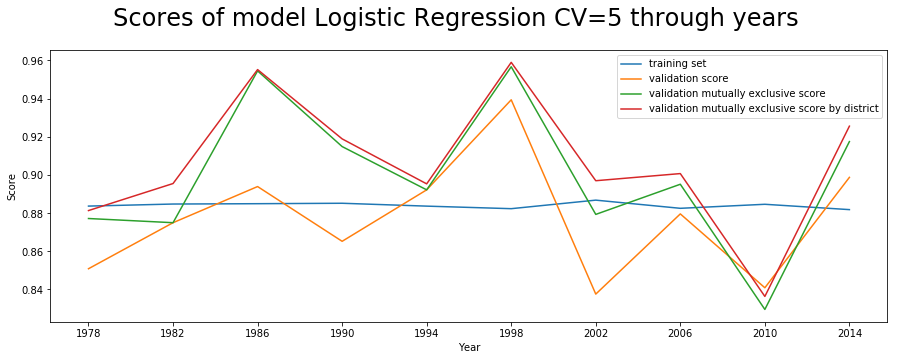

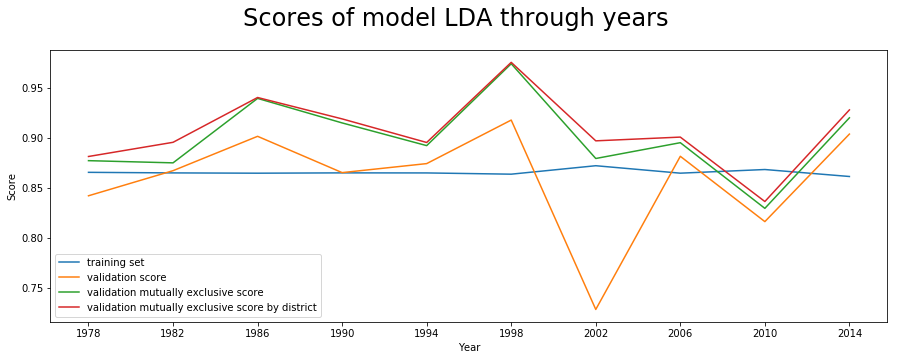

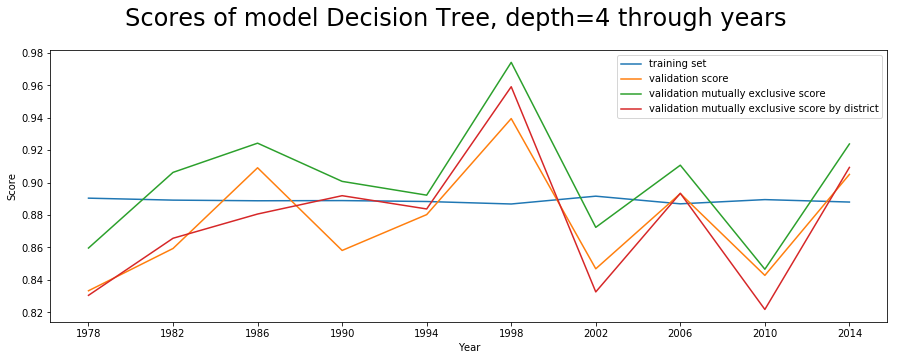

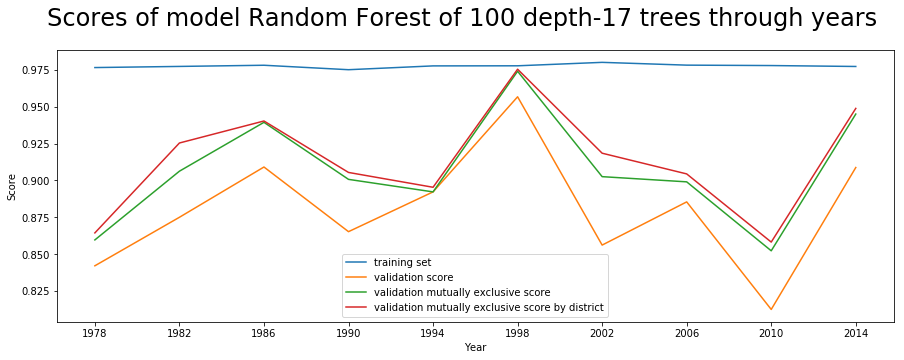

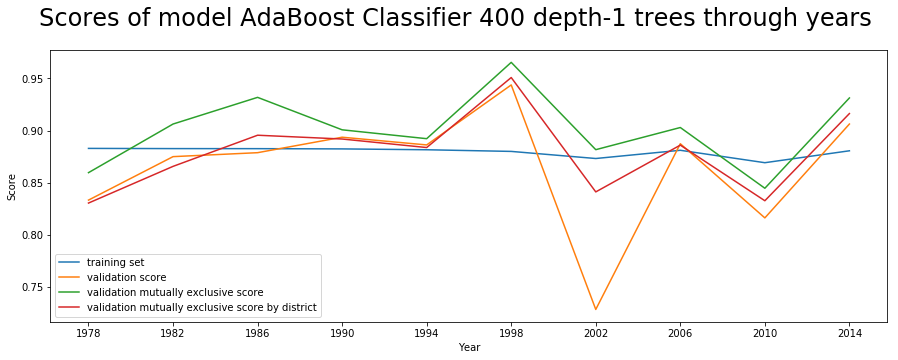

In [16]:
#train models using cross-validation through the years and calculate accuracies
modelListTrain(modelList, train_data, Midterm_recent_years)

<h3> Show models scores </h3> 

We notice how the single best performing model is random forest, with depth=17 and 100 iterations 

The mean score over the validation folds improved by doing the mutually exclusive selection. This score is still relative to the single candidates.

Then we extract only the predicted winners in each district and we compare them with the party of real winners. That is the validation set mutually excusive by district. 

That last score type is the one we aim to optimize, as our purpose is to predict the winning party in each district.

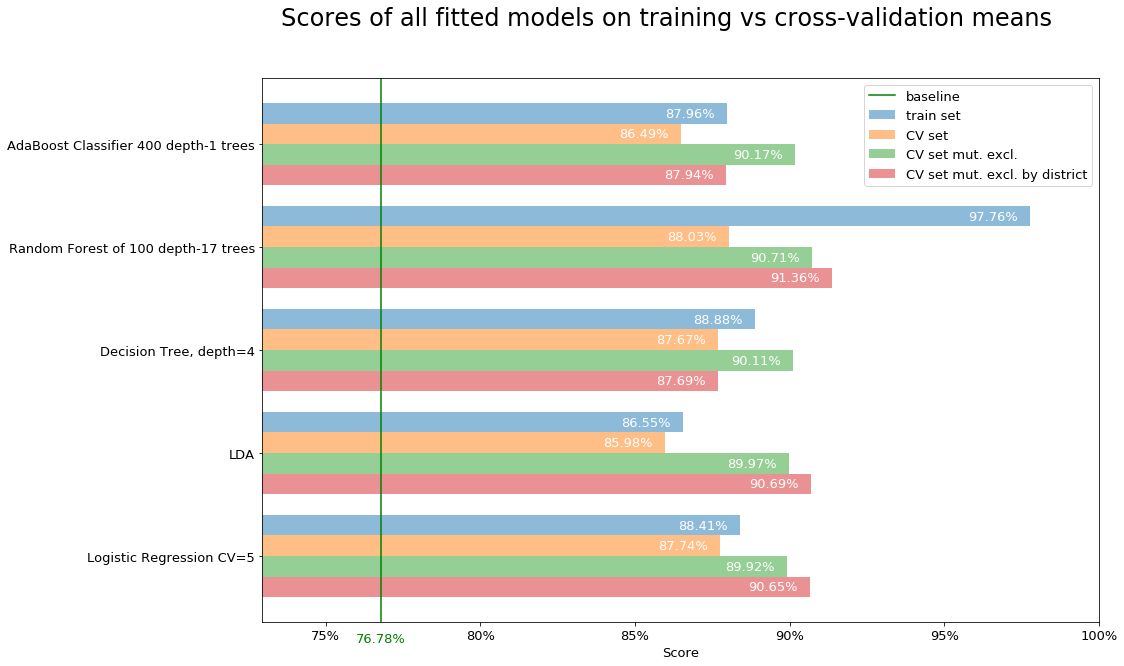

In [17]:
plotModelsScores(modelList, baseline_accuracy)

<h1> Feature importance </h1>

As random forest is our best model, we select features using the `var_sel_RF_2` function, which is a slight variation of the `var_sel_RF` function from the EDA phase. The main difference is that we don't need to split the dataset inside the function but we provide the datasets directly as inputs

In [18]:
#def var_sel_RF(forest_df,forest_cat=forest_cat,y_year=2018, threshold=0.003):
def var_sel_RF_2(x_train, y_train, x_test, y_test, threshold=0.003):
    #returns 1) sorted list of most important features
    #        2) Accuracy of model with all features and with selected features
    #thresold: minimum feature importance
    
    #x_train, y_train, x_test, y_test = one_hot_coding(forest_df,forest_cat,y_year)
    
    # Create a random forest classifier. number of trees set to 100
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    
    # Train the classifier
    clf.fit(x_train, y_train)
    feat_labels = x_train.columns
    feat_imp = []
    
    # name and gini importance of each feature
    for feature in zip(clf.feature_importances_,feat_labels):
        feat_imp.append(feature)
    feat_imp.sort(reverse=True)
    
    #sorted list with most important features
    feat_imp = list(filter(lambda x: x[0] > threshold, feat_imp))
    
    # Create a selector object that will use the random forest classifier to identify
    # features that have an importance of more than 0.003
    sfm = SelectFromModel(clf, threshold=threshold)

    # Train the selector
    sfm.fit(x_train, y_train)
    
    # Transform the data to create a new dataset containing only the most important features
    # Note: We have to apply the transform to both the training X and test X data.
    X_important_train = sfm.transform(x_train)
    X_important_test = sfm.transform(x_test)
    
    # Create a new random forest classifier for the most important features
    clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

    # Train the new classifier on the new dataset containing the most important features
    clf_important.fit(X_important_train, y_train)
    
    # Accuracy of model with all features
    y_pred = clf.predict(x_test)
    #print('Accuracy of model with all features: {}'.format(accuracy_score(y_test, y_pred)))
    
    # Accuracy of model with most important features
    y_important_pred = clf_important.predict(X_important_test)
    #print('Accuracy of model with most important features: {}'.format(accuracy_score(y_test, y_important_pred)))
    featList=pd.DataFrame(feat_imp)[1]
    if threshold>0.0:
        print('Features below threshold {}: {}'.format(threshold, list(set(x_train)-set(featList))))
    return feat_imp

Here we run feature importance taking 2018 data as test set and all remaining years as training. We take 0.01 as threshold:

In [19]:
x_train_designFeatures, x_test_designFeatures, y_train, y_test, df_districts, df_party = pre_process(house_df, 2018)
var_sel_RF_2(x_train_designFeatures, y_train, x_test_designFeatures, y_test, 0.01)

Features below threshold 0.01: ['own_president_party', 'party', 'own_last_house_majority', 'partisanship_3']


[(0.26206147725037143, 'is_incumbent'),
 (0.20108023310493323, 'Log10fundraising'),
 (0.14468732535625148, 'count_victories'),
 (0.09796038119929334, 'first_time_elected'),
 (0.07350195490398631, 'ownPartisan'),
 (0.0482982557728986, 'year'),
 (0.03807989685092155, 'last_own_party_Seats'),
 (0.030296322445838176, 'unemployement_rate_own_president'),
 (0.02981822182381279, 'unemployement_rate_president_opposition'),
 (0.014524993657334628, 'own_president_job_approval'),
 (0.012639476196769995, 'president_opposition_job_approval'),
 (0.011289015290131902, 'partisanship_2'),
 (0.010644151577198568, 'swingDistrict')]

Now we look at feature importance for each fold from `Midterm_recent_years`, store their values for each year and show the averages:

In [20]:
#evaluate feature importance for random forest, through all folds, excluding 2018 data
feat_df=pd.DataFrame(list(x_train_designFeatures), columns=['feature']).set_index('feature')
for year in Midterm_recent_years:
    #print('year: {}'.format(year))
    x_train_designFeatures, x_test_designFeatures, y_train, y_test, df_districts, df_party = pre_process(house_df[house_df['year']!=2018], year)
    feat_imp=var_sel_RF_2(x_train_designFeatures, y_train, x_test_designFeatures, y_test, 0)
    feat_df=feat_df.join(pd.DataFrame(feat_imp).set_index([1]).rename(index=str, columns={0:year}))
feat_df['mean']=feat_df.mean(axis=1)
feat_df['std']=feat_df.std(axis=1)
display(feat_df[['mean', 'std']].sort_values(by=['mean'], ascending=False))

,mean,std
feature,,
is_incumbent,0.277915,0.005145
Log10fundraising,0.200733,0.003773
count_victories,0.135327,0.004970
first_time_elected,0.094803,0.005741
ownPartisan,0.071608,0.003116
year,0.048395,0.001018
last_own_party_Seats,0.038416,0.001059
unemployement_rate_own_president,0.030516,0.000585
unemployement_rate_president_opposition,0.029744,0.000687


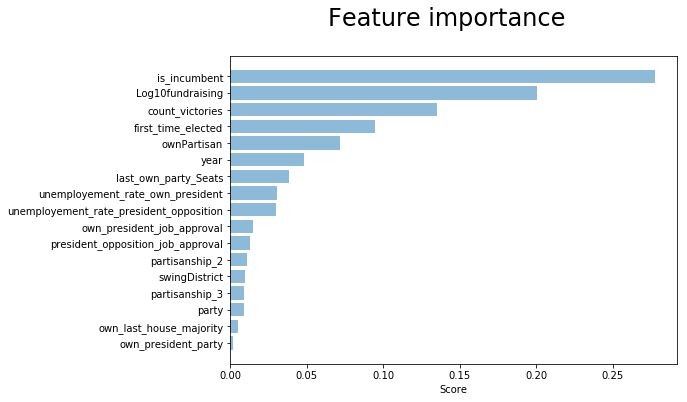

In [21]:
barPlotFeatImp(feat_df)    

We can conclude that feature importance is consistent through the years

In [22]:
#This function was used to evaluate feature importance for logistic regression
def featureImportance(x, y):
    scores, pvalues = chi2(x, y)
    featureImportance=pd.DataFrame([list(x), list(pvalues)]).T
    featureImportance.columns=['coeff', 'p-value']
    featureImportance=featureImportance.set_index('coeff')
    display(featureImportance)

<h1> Stacking </h1>

To do stacking, we will store the predictions of each model from a list of models into a dataframe, one column per model predictions and one for their probability

The `predictForStack` function generates those predictions for each year in a list of years and then appends them together

In [23]:
#Stacking all models
def predictForStack(df, years, modelList):
    train_data=df.copy()
    stackCols=['state', 'district', 'baseline', 'baseline_proba']
    for i in range(len(modelList)):
        stackCols.append('pred_{}'.format(i))
        stackCols.append('proba_{}'.format(i))
    stackCols.append('party')
    predictionsToStack=pd.DataFrame(columns=stackCols)
    for year in years:        
        #pre_process
        x_train_designFeatures, x_test_designFeatures, y_train, y_test, house_df_districts, house_df_party = pre_process(train_data, year)
        
        #baseline model predictions
        y_pred=baselineTrain_(train_data[train_data['year']!=year]).set_index(['state', 'district']).sort_index().astype(float) #train simple average model, remove 2018 results
        y_pred=y_pred.rename(index=str, columns={'party': 'baseline', 'proba': 'baseline_proba'})

        for i, model in enumerate(modelList):
            print('model: {}'.format(model['name']))
            print('year: {}'.format(year))
            #fit model
            fitted_model=model['model'].fit(x_train_designFeatures, y_train)

            #generate predictions and calculate accuracy
            Accu_train, Accu_val, Accu_val_2, pred_df = MutuallyExclusivePredictions(fitted_model, x_train_designFeatures, x_test_designFeatures, y_train, y_test, house_df_districts, house_df_party)

            #predictions by district and winning party only
            y_pred_i=pred_df[pred_df['won_pred']==1].set_index(['state', 'district']).sort_index()
            y_pred_i['proba_{}'.format(i)]=y_pred_i['rel_won_proba']
            y_pred_i=y_pred_i.drop(columns=['abs_won_proba', 'won_pred', 'rel_won_proba'])
            y_pred_i=y_pred_i.rename(index=str, columns={'party': 'pred_{}'.format(i)})

            #Add column with current model predictions
            y_pred = pd.concat([y_pred, y_pred_i], axis=1).fillna(-1)
            y_pred['proba_{}'.format(i)]=y_pred['proba_{}'.format(i)].replace(-1,0)
        y_pred['baseline_proba']=y_pred['baseline_proba'].replace(-1,0)
        #Add last column with actual results
        y_val=winnerFilter_(train_data[train_data['year']==year]).set_index(['state', 'district']).sort_index() #extract winner party for each district in 2018
        y_pred=y_pred.join(y_val).dropna()

        #Append all models predictions for current year to the other years' predictions
        predictionsToStack=predictionsToStack.append(y_pred.reset_index(drop=False)[stackCols])  
    #if asking only for one year, return predictions by state and district, without actual results (it means it's for 2018)
    if (len(years)==1): 
        return predictionsToStack.drop('party', axis=1).set_index(['state', 'district']).sort_index()
    #if asking for several years, predictions and actual results will be used to fit a stacking model, so remove state, district index and include actual results
    return predictionsToStack.drop(columns=['state', 'district'])

We will predict results for a list of years (excluding 2018), using the remaining years (still excluding 2018) data as training. 

Then we will use this data to fit the stacking linear model

First we generate the predictions for all available models:

In [24]:
#Generate predictions for stacking
predictionsToStack=predictForStack(train_data, Midterm_recent_years, modelList)

model: Logistic Regression CV=5
year: 2014
model: LDA
year: 2014
model: Decision Tree, depth=4
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
22 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
17,Arkansas,District 2,2.0
22,California,District 11,2.0
37,California,District 25,2.0
46,California,District 33,2.0
48,California,District 35,2.0
76,Colorado,District 4,2.0
158,Iowa,District 1,2.0
179,Maine,District 2,2.0
193,Massachusetts,District 6,2.0
199,Michigan,District 11,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8114,Arkansas,District 2,0.0,0.177745,1.0,0.355489,0.5
8120,Arkansas,District 2,1.0,0.177745,1.0,0.355489,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8114,Arkansas,District 2,-0.904043,0.0,0.891256,-0.525298,-0.525246,0.431761,1.0,0.0,0.0,1.0,0.0,0.0,-0.459887,0.896607,-0.991331,0.909545,-0.918595,0.177745
8120,Arkansas,District 2,-0.904043,1.0,0.891256,-0.525298,-0.525246,0.210567,0.0,1.0,0.0,1.0,0.0,0.0,0.460877,-0.980536,0.886373,-0.908020,0.902908,0.177745


The conflict in California, District 25 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in California, District 35 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Washington, District 4 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Random Forest of 100 depth-17 trees
year: 2014
model: AdaBoost Classifier 400 depth-1 trees
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
19 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
17,Arkansas,District 2,2.0
22,California,District 11,2.0
37,California,District 25,2.0
46,California,District 33,2.0
158,Iowa,District 1,2.0
179,Maine,District 2,2.0
193,Massachusetts,District 6,2.0
199,Michigan,District 11,2.0
208,Michigan,District 8,2.0
240,New Jersey,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8114,Arkansas,District 2,0.0,0.405907,1.0,0.811813,0.5
8120,Arkansas,District 2,1.0,0.405907,1.0,0.811813,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8114,Arkansas,District 2,-0.904043,0.0,0.891256,-0.525298,-0.525246,0.431761,1.0,0.0,0.0,1.0,0.0,0.0,-0.459887,0.896607,-0.991331,0.909545,-0.918595,0.405907
8120,Arkansas,District 2,-0.904043,1.0,0.891256,-0.525298,-0.525246,0.210567,0.0,1.0,0.0,1.0,0.0,0.0,0.460877,-0.980536,0.886373,-0.908020,0.902908,0.405907


The conflict in California, District 25 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Washington, District 4 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Logistic Regression CV=5
year: 2010
model: LDA
year: 2010
model: Decision Tree, depth=4
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
17 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
10,Arizona,District 3,2.0
16,Arkansas,District 1,2.0
17,Arkansas,District 2,2.0
30,California,District 19,3.0
45,California,District 33,2.0
84,Delaware,At-Large,2.0
104,Florida,District 5,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.169442,1.0,0.338885,0.5
6570,Alabama,District 5,0.0,0.169442,1.0,0.338885,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,-0.908171,1.0,0.69794,-0.518637,-0.519557,0.213818,0.0,0.0,0.0,1.0,0.0,0.0,-1.156670,-0.984363,0.892834,-0.911645,1.860769,0.169442
6570,Alabama,District 5,-0.908171,0.0,0.69794,-0.518637,-0.519557,0.254646,1.0,1.0,0.0,1.0,0.0,0.0,1.153816,0.896663,-0.988160,1.838533,-0.917740,0.169442


model: Random Forest of 100 depth-17 trees
year: 2010
model: AdaBoost Classifier 400 depth-1 trees
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
10 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
10,Arizona,District 3,2.0
16,Arkansas,District 1,2.0
17,Arkansas,District 2,2.0
84,Delaware,At-Large,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0
221,Ohio,District 2,2.0
234,Rhode Island,District 1,2.0
270,Virginia,District 5,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.406221,1.0,0.812442,0.5
6570,Alabama,District 5,0.0,0.406221,1.0,0.812442,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,-0.908171,1.0,0.69794,-0.518637,-0.519557,0.213818,0.0,0.0,0.0,1.0,0.0,0.0,-1.156670,-0.984363,0.892834,-0.911645,1.860769,0.406221
6570,Alabama,District 5,-0.908171,0.0,0.69794,-0.518637,-0.519557,0.254646,1.0,1.0,0.0,1.0,0.0,0.0,1.153816,0.896663,-0.988160,1.838533,-0.917740,0.406221


model: Logistic Regression CV=5
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.161234,0.0,0.624092,0.258349
5538,Texas,District 22,1.0,0.231429,1.0,0.624092,0.370825
5539,Texas,District 22,1.0,0.231429,1.0,0.624092,0.370825


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,-0.905769,0.0,0.533415,-0.518873,-0.518943,0.150083,0.0,0.0,0.0,0.0,0.0,0.0,-0.424937,-0.984829,0.951740,-0.913506,0.318491,0.161234
5538,Texas,District 22,-0.905769,1.0,0.533415,-0.518873,-0.518943,0.150083,1.0,1.0,0.0,0.0,0.0,0.0,0.424673,0.954201,-0.987421,0.315819,-0.918027,0.231429
5539,Texas,District 22,-0.905769,1.0,0.533415,-0.518873,-0.518943,0.150083,1.0,1.0,0.0,0.0,0.0,0.0,0.424673,0.954201,-0.987421,0.315819,-0.918027,0.231429


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: LDA
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.062984,0.0,0.284783,0.221166
5538,Texas,District 22,1.0,0.110899,1.0,0.284783,0.389417
5539,Texas,District 22,1.0,0.110899,1.0,0.284783,0.389417


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,-0.905769,0.0,0.533415,-0.518873,-0.518943,0.150083,0.0,0.0,0.0,0.0,0.0,0.0,-0.424937,-0.984829,0.951740,-0.913506,0.318491,0.062984
5538,Texas,District 22,-0.905769,1.0,0.533415,-0.518873,-0.518943,0.150083,1.0,1.0,0.0,0.0,0.0,0.0,0.424673,0.954201,-0.987421,0.315819,-0.918027,0.110899
5539,Texas,District 22,-0.905769,1.0,0.533415,-0.518873,-0.518943,0.150083,1.0,1.0,0.0,0.0,0.0,0.0,0.424673,0.954201,-0.987421,0.315819,-0.918027,0.110899


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Decision Tree, depth=4
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
12 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
15,Arizona,District 8,2.0
86,Florida,District 11,2.0
108,Florida,District 9,2.0
110,Georgia,District 10,2.0
115,Georgia,District 3,2.0
120,Georgia,District 8,2.0
121,Georgia,District 9,2.0
137,Iowa,District 1,2.0
229,Pennsylvania,District 10,2.0
245,Texas,District 20,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5533,Arizona,District 8,0.0,0.188011,1.0,0.376022,0.5
5534,Arizona,District 8,1.0,0.188011,1.0,0.376022,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5533,Arizona,District 8,-0.905769,0.0,0.533415,-0.518873,-0.518943,0.652626,0.0,0.0,0.0,0.0,0.0,0.0,-0.424937,-0.984829,0.951740,-0.913506,0.318491,0.188011
5534,Arizona,District 8,-0.905769,1.0,0.533415,-0.518873,-0.518943,0.652626,1.0,1.0,0.0,0.0,0.0,0.0,0.424673,0.954201,-0.987421,0.315819,-0.918027,0.188011


model: Random Forest of 100 depth-17 trees
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.186879,0.0,1.25952,0.148373
5538,Texas,District 22,1.0,0.536321,1.0,1.25952,0.425813
5539,Texas,District 22,1.0,0.536321,1.0,1.25952,0.425813


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,-0.905769,0.0,0.533415,-0.518873,-0.518943,0.150083,0.0,0.0,0.0,0.0,0.0,0.0,-0.424937,-0.984829,0.951740,-0.913506,0.318491,0.186879
5538,Texas,District 22,-0.905769,1.0,0.533415,-0.518873,-0.518943,0.150083,1.0,1.0,0.0,0.0,0.0,0.0,0.424673,0.954201,-0.987421,0.315819,-0.918027,0.536321
5539,Texas,District 22,-0.905769,1.0,0.533415,-0.518873,-0.518943,0.150083,1.0,1.0,0.0,0.0,0.0,0.0,0.424673,0.954201,-0.987421,0.315819,-0.918027,0.536321


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: AdaBoost Classifier 400 depth-1 trees
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
12 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
15,Arizona,District 8,2.0
86,Florida,District 11,2.0
108,Florida,District 9,2.0
110,Georgia,District 10,2.0
115,Georgia,District 3,2.0
120,Georgia,District 8,2.0
121,Georgia,District 9,2.0
137,Iowa,District 1,2.0
229,Pennsylvania,District 10,2.0
245,Texas,District 20,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5533,Arizona,District 8,0.0,0.408714,1.0,0.817427,0.5
5534,Arizona,District 8,1.0,0.408714,1.0,0.817427,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5533,Arizona,District 8,-0.905769,0.0,0.533415,-0.518873,-0.518943,0.652626,0.0,0.0,0.0,0.0,0.0,0.0,-0.424937,-0.984829,0.951740,-0.913506,0.318491,0.408714
5534,Arizona,District 8,-0.905769,1.0,0.533415,-0.518873,-0.518943,0.652626,1.0,1.0,0.0,0.0,0.0,0.0,0.424673,0.954201,-0.987421,0.315819,-0.918027,0.408714


model: Logistic Regression CV=5
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.401848,1.0,1.205545,0.333333
4460,Louisiana,District 1,1.0,0.401848,1.0,1.205545,0.333333
4461,Louisiana,District 1,1.0,0.401848,1.0,1.205545,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.401848
4460,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.401848
4461,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.401848


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: LDA
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.176881,1.0,0.530642,0.333333
4460,Louisiana,District 1,1.0,0.176881,1.0,0.530642,0.333333
4461,Louisiana,District 1,1.0,0.176881,1.0,0.530642,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.176881
4460,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.176881
4461,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.176881


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Decision Tree, depth=4
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
30 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
14,Arizona,District 8,2.0
15,Arkansas,District 1,2.0
18,Arkansas,District 4,2.0
28,California,District 18,2.0
32,California,District 21,2.0
74,Colorado,District 4,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4511,Alabama,District 5,0.0,0.168421,1.0,0.336842,0.5
4512,Alabama,District 5,1.0,0.168421,1.0,0.336842,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4511,Alabama,District 5,-0.924743,0.0,0.370007,-0.532362,-0.531787,0.005329,0.0,0.0,0.0,1.0,0.0,0.0,-0.126579,-0.981452,0.948793,-0.905028,0.699480,0.168421
4512,Alabama,District 5,-0.924743,1.0,0.370007,-0.532362,-0.531787,0.005329,1.0,1.0,0.0,1.0,0.0,0.0,0.128864,0.958070,-0.991078,0.698522,-0.915336,0.168421


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Random Forest of 100 depth-17 trees
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.678738,1.0,2.036214,0.333333
4460,Louisiana,District 1,1.0,0.678738,1.0,2.036214,0.333333
4461,Louisiana,District 1,1.0,0.678738,1.0,2.036214,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.678738
4460,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.678738
4461,Louisiana,District 1,-0.924743,1.0,0.370007,-0.532362,-0.531787,-2.013639,1.0,1.0,1.0,0.0,0.0,1.0,0.128864,0.95807,-0.991078,0.698522,-0.915336,0.678738


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: AdaBoost Classifier 400 depth-1 trees
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
30 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
14,Arizona,District 8,2.0
15,Arkansas,District 1,2.0
18,Arkansas,District 4,2.0
28,California,District 18,2.0
32,California,District 21,2.0
74,Colorado,District 4,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4511,Alabama,District 5,0.0,0.405382,1.0,0.810763,0.5
4512,Alabama,District 5,1.0,0.405382,1.0,0.810763,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4511,Alabama,District 5,-0.924743,0.0,0.370007,-0.532362,-0.531787,0.005329,0.0,0.0,0.0,1.0,0.0,0.0,-0.126579,-0.981452,0.948793,-0.905028,0.699480,0.405382
4512,Alabama,District 5,-0.924743,1.0,0.370007,-0.532362,-0.531787,0.005329,1.0,1.0,0.0,1.0,0.0,0.0,0.128864,0.958070,-0.991078,0.698522,-0.915336,0.405382


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Logistic Regression CV=5
year: 1998
model: LDA
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.062131,0.0,0.193147,0.321677
3719,California,District 1,1.0,0.065508,1.0,0.193147,0.339161
3720,California,District 1,1.0,0.065508,1.0,0.193147,0.339161


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.908119,0.0,0.208818,-0.525504,-0.524906,0.093515,1.0,0.0,0.0,1.0,0.0,0.0,-0.31434,1.188612,-0.990281,0.358551,-0.917771,0.062131
3719,California,District 1,-0.908119,1.0,0.208818,-0.525504,-0.524906,0.093515,0.0,1.0,0.0,1.0,0.0,0.0,0.31661,-0.983169,1.181935,-0.909648,0.358830,0.065508
3720,California,District 1,-0.908119,1.0,0.208818,-0.525504,-0.524906,0.093515,0.0,1.0,0.0,1.0,0.0,0.0,0.31661,-0.983169,1.181935,-0.909648,0.358830,0.065508


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Decision Tree, depth=4
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,3.0
83,New York,District 13,2.0
92,New York,District 22,2.0
97,New York,District 27,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.222222,1.0,0.666667,0.333333
3719,California,District 1,1.0,0.222222,1.0,0.666667,0.333333
3720,California,District 1,1.0,0.222222,1.0,0.666667,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.908119,0.0,0.208818,-0.525504,-0.524906,0.093515,1.0,0.0,0.0,1.0,0.0,0.0,-0.31434,1.188612,-0.990281,0.358551,-0.917771,0.222222
3719,California,District 1,-0.908119,1.0,0.208818,-0.525504,-0.524906,0.093515,0.0,1.0,0.0,1.0,0.0,0.0,0.31661,-0.983169,1.181935,-0.909648,0.358830,0.222222
3720,California,District 1,-0.908119,1.0,0.208818,-0.525504,-0.524906,0.093515,0.0,1.0,0.0,1.0,0.0,0.0,0.31661,-0.983169,1.181935,-0.909648,0.358830,0.222222


model: Random Forest of 100 depth-17 trees
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.065005,0.0,0.321826,0.201990
3719,California,District 1,1.0,0.128410,1.0,0.321826,0.399005
3720,California,District 1,1.0,0.128410,1.0,0.321826,0.399005


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.908119,0.0,0.208818,-0.525504,-0.524906,0.093515,1.0,0.0,0.0,1.0,0.0,0.0,-0.31434,1.188612,-0.990281,0.358551,-0.917771,0.065005
3719,California,District 1,-0.908119,1.0,0.208818,-0.525504,-0.524906,0.093515,0.0,1.0,0.0,1.0,0.0,0.0,0.31661,-0.983169,1.181935,-0.909648,0.358830,0.128410
3720,California,District 1,-0.908119,1.0,0.208818,-0.525504,-0.524906,0.093515,0.0,1.0,0.0,1.0,0.0,0.0,0.31661,-0.983169,1.181935,-0.909648,0.358830,0.128410


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: AdaBoost Classifier 400 depth-1 trees
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,3.0
83,New York,District 13,2.0
92,New York,District 22,2.0
97,New York,District 27,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.409137,1.0,1.22741,0.333333
3719,California,District 1,1.0,0.409137,1.0,1.22741,0.333333
3720,California,District 1,1.0,0.409137,1.0,1.22741,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.908119,0.0,0.208818,-0.525504,-0.524906,0.093515,1.0,0.0,0.0,1.0,0.0,0.0,-0.31434,1.188612,-0.990281,0.358551,-0.917771,0.409137
3719,California,District 1,-0.908119,1.0,0.208818,-0.525504,-0.524906,0.093515,0.0,1.0,0.0,1.0,0.0,0.0,0.31661,-0.983169,1.181935,-0.909648,0.358830,0.409137
3720,California,District 1,-0.908119,1.0,0.208818,-0.525504,-0.524906,0.093515,0.0,1.0,0.0,1.0,0.0,0.0,0.31661,-0.983169,1.181935,-0.909648,0.358830,0.409137


model: Logistic Regression CV=5
year: 1994
model: LDA
year: 1994
model: Decision Tree, depth=4
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
37,California,District 44,2.0
64,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3294,California,District 44,0.0,0.220151,1.0,0.440303,0.5
3354,California,District 44,1.0,0.220151,1.0,0.440303,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3294,California,District 44,-0.907499,0.0,0.052753,-0.527344,-0.527182,0.30113,1.0,1.0,0.0,1.0,0.0,0.0,1.195709,1.187299,-0.990527,0.733431,-0.915850,0.220151
3354,California,District 44,-0.907499,1.0,0.052753,-0.527344,-0.527182,0.30113,0.0,0.0,0.0,1.0,0.0,0.0,-1.193918,-0.983013,1.180121,-0.907410,0.736017,0.220151


model: Random Forest of 100 depth-17 trees
year: 1994
model: AdaBoost Classifier 400 depth-1 trees
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
37,California,District 44,2.0
64,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3294,California,District 44,0.0,0.408496,1.0,0.816992,0.5
3354,California,District 44,1.0,0.408496,1.0,0.816992,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3294,California,District 44,-0.907499,0.0,0.052753,-0.527344,-0.527182,0.30113,1.0,1.0,0.0,1.0,0.0,0.0,1.195709,1.187299,-0.990527,0.733431,-0.915850,0.408496
3354,California,District 44,-0.907499,1.0,0.052753,-0.527344,-0.527182,0.30113,0.0,0.0,0.0,1.0,0.0,0.0,-1.193918,-0.983013,1.180121,-0.907410,0.736017,0.408496


model: Logistic Regression CV=5
year: 1990
model: LDA
year: 1990
model: Decision Tree, depth=4
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
45,Colorado,District 4,2.0
70,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3062,Colorado,District 4,0.0,0.219359,1.0,0.438717,0.5
3063,Colorado,District 4,1.0,0.219359,1.0,0.438717,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3062,Colorado,District 4,-0.907765,0.0,-0.102275,-0.523513,-0.523862,0.379619,0.0,1.0,0.0,1.0,0.0,0.0,1.237058,-0.983563,1.413230,-0.907511,0.765490,0.219359
3063,Colorado,District 4,-0.907765,1.0,-0.102275,-0.523513,-0.523862,0.379619,1.0,0.0,0.0,1.0,0.0,0.0,-1.234712,1.420308,-0.991066,0.762707,-0.915934,0.219359


model: Random Forest of 100 depth-17 trees
year: 1990
model: AdaBoost Classifier 400 depth-1 trees
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
45,Colorado,District 4,2.0
70,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3062,Colorado,District 4,0.0,0.408459,1.0,0.816918,0.5
3063,Colorado,District 4,1.0,0.408459,1.0,0.816918,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3062,Colorado,District 4,-0.907765,0.0,-0.102275,-0.523513,-0.523862,0.379619,0.0,1.0,0.0,1.0,0.0,0.0,1.237058,-0.983563,1.413230,-0.907511,0.765490,0.408459
3063,Colorado,District 4,-0.907765,1.0,-0.102275,-0.523513,-0.523862,0.379619,1.0,0.0,0.0,1.0,0.0,0.0,-1.234712,1.420308,-0.991066,0.762707,-0.915934,0.408459


model: Logistic Regression CV=5
year: 1986
model: LDA
year: 1986
model: Decision Tree, depth=4
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
6 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
11,California,District 2,2.0
13,California,District 21,2.0
54,Maryland,District 8,2.0
62,Utah,District 2,2.0
65,Virginia,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2735,California,District 12,1.0,0.21814,1.0,0.43628,0.5
2736,California,District 12,0.0,0.21814,1.0,0.43628,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2735,California,District 12,-0.909019,1.0,-0.2572,-0.523678,-0.523866,0.634395,1.0,0.0,0.0,1.0,0.0,0.0,-1.027179,1.094214,-0.990337,1.078907,-0.915517,0.21814
2736,California,District 12,-0.909019,0.0,-0.2572,-0.523678,-0.523866,0.634395,0.0,1.0,0.0,1.0,0.0,0.0,1.029704,-0.983083,1.087296,-0.907294,1.084153,0.21814


model: Random Forest of 100 depth-17 trees
year: 1986
model: AdaBoost Classifier 400 depth-1 trees
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
5 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
11,California,District 2,2.0
13,California,District 21,2.0
54,Maryland,District 8,2.0
65,Virginia,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2735,California,District 12,1.0,0.408643,1.0,0.817286,0.5
2736,California,District 12,0.0,0.408643,1.0,0.817286,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2735,California,District 12,-0.909019,1.0,-0.2572,-0.523678,-0.523866,0.634395,1.0,0.0,0.0,1.0,0.0,0.0,-1.027179,1.094214,-0.990337,1.078907,-0.915517,0.408643
2736,California,District 12,-0.909019,0.0,-0.2572,-0.523678,-0.523866,0.634395,0.0,1.0,0.0,1.0,0.0,0.0,1.029704,-0.983083,1.087296,-0.907294,1.084153,0.408643


model: Logistic Regression CV=5
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.231145,1.0,0.654716,0.353047
2528,California,District 43,0.0,0.192425,0.0,0.654716,0.293907
2569,California,District 43,1.0,0.231145,1.0,0.654716,0.353047


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,-0.909482,1.0,-0.412345,-0.5259,-0.525692,-0.062539,1.0,0.0,0.0,1.0,0.0,0.0,-0.734935,1.094421,-0.990568,2.074204,-0.919018,0.231145
2528,California,District 43,-0.909482,0.0,-0.412345,-0.5259,-0.525692,-0.062539,0.0,1.0,0.0,1.0,0.0,0.0,0.736978,-0.982864,1.087002,-0.910201,2.085907,0.192425
2569,California,District 43,-0.909482,1.0,-0.412345,-0.5259,-0.525692,-0.062539,1.0,0.0,0.0,1.0,0.0,0.0,-0.734935,1.094421,-0.990568,2.074204,-0.919018,0.231145


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: LDA
year: 1982


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.095103,1.0,0.241411,0.393945
2528,California,District 43,0.0,0.051206,0.0,0.241411,0.212109
2569,California,District 43,1.0,0.095103,1.0,0.241411,0.393945


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,-0.909482,1.0,-0.412345,-0.5259,-0.525692,-0.062539,1.0,0.0,0.0,1.0,0.0,0.0,-0.734935,1.094421,-0.990568,2.074204,-0.919018,0.095103
2528,California,District 43,-0.909482,0.0,-0.412345,-0.5259,-0.525692,-0.062539,0.0,1.0,0.0,1.0,0.0,0.0,0.736978,-0.982864,1.087002,-0.910201,2.085907,0.051206
2569,California,District 43,-0.909482,1.0,-0.412345,-0.5259,-0.525692,-0.062539,1.0,0.0,0.0,1.0,0.0,0.0,-0.734935,1.094421,-0.990568,2.074204,-0.919018,0.095103


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Decision Tree, depth=4
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
6 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
9,California,District 18,2.0
19,California,District 27,2.0
36,California,District 43,3.0
37,California,District 44,2.0
40,California,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2445,California,District 12,1.0,0.217566,1.0,0.435132,0.5
2500,California,District 12,0.0,0.217566,1.0,0.435132,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2445,California,District 12,-0.909482,1.0,-0.412345,-0.5259,-0.525692,0.634763,1.0,0.0,0.0,1.0,0.0,0.0,-0.734935,1.094421,-0.990568,2.074204,-0.919018,0.217566
2500,California,District 12,-0.909482,0.0,-0.412345,-0.5259,-0.525692,0.634763,0.0,1.0,0.0,1.0,0.0,0.0,0.736978,-0.982864,1.087002,-0.910201,2.085907,0.217566


model: Random Forest of 100 depth-17 trees
year: 1982
model: AdaBoost Classifier 400 depth-1 trees
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
6 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
9,California,District 18,2.0
19,California,District 27,2.0
36,California,District 43,3.0
37,California,District 44,2.0
40,California,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2445,California,District 12,1.0,0.408167,1.0,0.816335,0.5
2500,California,District 12,0.0,0.408167,1.0,0.816335,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2445,California,District 12,-0.909482,1.0,-0.412345,-0.5259,-0.525692,0.634763,1.0,0.0,0.0,1.0,0.0,0.0,-0.734935,1.094421,-0.990568,2.074204,-0.919018,0.408167
2500,California,District 12,-0.909482,0.0,-0.412345,-0.5259,-0.525692,0.634763,0.0,1.0,0.0,1.0,0.0,0.0,0.736978,-0.982864,1.087002,-0.910201,2.085907,0.408167


model: Logistic Regression CV=5
year: 1978
model: LDA
year: 1978
model: Decision Tree, depth=4
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
9,California,District 18,2.0
25,California,District 33,2.0
42,Colorado,District 3,2.0
48,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2214,California,District 18,1.0,0.218861,1.0,0.437722,0.5
2216,California,District 18,0.0,0.218861,1.0,0.437722,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2214,California,District 18,-0.908567,1.0,-0.567381,-0.525551,-0.525457,0.147788,0.0,0.0,0.0,1.0,0.0,0.0,-2.209922,-0.983016,0.796337,-0.907662,0.737173,0.218861
2216,California,District 18,-0.908567,0.0,-0.567381,-0.525551,-0.525457,0.147788,1.0,1.0,0.0,1.0,0.0,0.0,2.212019,0.803759,-0.990708,0.734766,-0.916271,0.218861


model: Random Forest of 100 depth-17 trees
year: 1978
model: AdaBoost Classifier 400 depth-1 trees
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
9,California,District 18,2.0
25,California,District 33,2.0
42,Colorado,District 3,2.0
48,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2214,California,District 18,1.0,0.407383,1.0,0.814765,0.5
2216,California,District 18,0.0,0.407383,1.0,0.814765,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2214,California,District 18,-0.908567,1.0,-0.567381,-0.525551,-0.525457,0.147788,0.0,0.0,0.0,1.0,0.0,0.0,-2.209922,-0.983016,0.796337,-0.907662,0.737173,0.407383
2216,California,District 18,-0.908567,0.0,-0.567381,-0.525551,-0.525457,0.147788,1.0,1.0,0.0,1.0,0.0,0.0,2.212019,0.803759,-0.990708,0.734766,-0.916271,0.407383


Here we see how the predictions look like. The name of the columns are kept short as the model names are too long. 

A legend is displayed to identify the model

In [25]:
#display prediction table for stacking and model names legenda
display(predictionsToStack.head())
for i in range(len(modelList)):
    print(i, modelList[i]['name'])

,baseline,baseline_proba,pred_0,proba_0,pred_1,proba_1,pred_2,proba_2,pred_3,proba_3,pred_4,proba_4,party
0,1.0,1.000000,1.0,0.963650,1.0,0.992239,1.0,0.943496,1.0,0.978861,1.0,0.646857,1.0
1,1.0,0.857143,1.0,0.960939,1.0,0.991644,1.0,0.943496,1.0,0.998370,1.0,0.657175,1.0
2,1.0,1.000000,1.0,0.965379,1.0,0.992509,1.0,0.943496,1.0,0.998435,1.0,0.657175,1.0
3,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
4,0.0,0.571429,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0


0 Logistic Regression CV=5
1 LDA
2 Decision Tree, depth=4
3 Random Forest of 100 depth-17 trees
4 AdaBoost Classifier 400 depth-1 trees


Then, we select which models to use to train our stacking model.

The selection is done by looking at the coefficients of the model, taking only the biggest ones

In [26]:
#Select which model predictions to stack
selCols=[4,8,12]
X=predictionsToStack.iloc[:,selCols].drop('party', axis=1).astype(float)
y=predictionsToStack.iloc[:,selCols]['party'].astype(float)
stackingModel = LogisticRegression(C=1000, solver='lbfgs').fit(X,y)
print('Training accuracy of the stacking model: {:.2%}'.format(stackingModel.score(X,y)))
print('Stacking model coefficients: {}'.format(stackingModel.coef_))

Training accuracy of the stacking model: 91.39%
Stacking model coefficients: [[1.83039939 3.14929837]]


Now we need to generate the predictions for 2018 data using all models: 

In [27]:
#split dataset using 2018 data as test set
year=2018
#data=house_df[(house_df['year']>=yearStart)]
data=train_data.append(test_data)
predictions2018toStack=predictForStack(data, [year], modelList)

model: Logistic Regression CV=5
year: 2018
model: LDA
year: 2018
model: Decision Tree, depth=4
year: 2018


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
28 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
95,Florida,District 17,2.0
106,Florida,District 27,2.0
144,Illinois,District 4,2.0
212,Minnesota,District 1,2.0
222,Mississippi,District 3,2.0
239,Nevada,District 4,2.0
244,New Jersey,District 11,2.0
246,New Jersey,District 2,2.0
296,North Carolina,District 9,2.0
297,North Dakota,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
9865,Florida,District 17,1.0,0.217172,1.0,0.434343,0.5
9869,Florida,District 17,0.0,0.217172,1.0,0.434343,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
9865,Florida,District 17,-0.908244,1.0,0.974413,-0.525453,-0.525503,-0.007582,1.0,1.0,0.0,1.0,0.0,0.0,0.681514,0.570016,-0.990684,0.141504,-0.916945,0.217172
9869,Florida,District 17,-0.908244,0.0,0.974413,-0.525453,-0.525503,-0.007582,0.0,0.0,0.0,1.0,0.0,0.0,-0.679495,-0.983090,0.562641,-0.908416,0.139951,0.217172


model: Random Forest of 100 depth-17 trees
year: 2018
model: AdaBoost Classifier 400 depth-1 trees
year: 2018


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
31 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
16,Arizona,District 9,2.0
95,Florida,District 17,2.0
106,Florida,District 27,2.0
200,Michigan,District 11,2.0
212,Minnesota,District 1,2.0
219,Minnesota,District 8,2.0
222,Mississippi,District 3,2.0
239,Nevada,District 4,2.0
240,New Hampshire,District 1,2.0
244,New Jersey,District 11,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
9291,Arizona,District 9,0.0,0.408031,1.0,0.816062,0.5
9292,Arizona,District 9,1.0,0.408031,1.0,0.816062,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,partisanship_2,partisanship_3,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
9291,Arizona,District 9,-0.908244,0.0,0.974413,-0.525453,-0.525503,0.492675,0.0,0.0,0.0,0.0,0.0,0.0,-0.679495,-0.983090,0.562641,-0.908416,0.139951,0.408031
9292,Arizona,District 9,-0.908244,1.0,0.974413,-0.525453,-0.525503,0.307241,1.0,1.0,0.0,0.0,0.0,0.0,0.681514,0.570016,-0.990684,0.141504,-0.916945,0.408031


Then we stack the 2018 predictions according to the selection used for model fit.

We have obtained our final predictions

In [28]:
selCols_=selCols[:-1]
X=predictions2018toStack.iloc[:,selCols_].copy().astype(float)
X['stackedPredictions']=stackingModel.predict(X)
X, y_pred_stacked_2018=X.drop('stackedPredictions', axis=1), X['stackedPredictions']
pred2018_accuracy=districtAccuracy(y_pred_stacked_2018, 2018, 'stackedPredictions', 0) #, partyWonCol='party', set_index=1)
print('The accuracy of our predictions for 2018 midterm elections is {:.2%}'.format(pred2018_accuracy))
pred2018=districtPredictions(y_pred_stacked_2018, 2018, 'stackedPredictions', 0) #year, partyWonCol='party', set_index=1):

The accuracy of our predictions for 2018 midterm elections is 89.89%


What we need to do now is to prepare the table for the map, in csv format, with predictions, probabilities and actual results

In [29]:
#calculate stacked probabilities 
probabilities=list(np.array(selCols_)+1)
pred2018['proba']=predictions2018toStack.iloc[:,probabilities].dot(stackingModel.coef_.T)/np.sum(stackingModel.coef_)

In [30]:
#Salve .csv file
pred2018=pred2018.rename(index=str, columns={'partyWon':'won', 'stackedPredictions':'won_pred', 'proba':'rel_won_proba'})
pred2018['correct_pred']=(pred2018['won']==pred2018['won_pred'])
pred2018.to_csv('data/final_results_map.csv', index=True)
display(pred2018.head())

won  won_pred  rel_won_proba  correct_pred
state   district                                              
Alabama District 1    1       1.0       0.983862          True
        District 2    1       1.0       0.960887          True
        District 3    1       1.0       0.871858          True
        District 4    1       1.0       0.986864          True
        District 5    1       1.0       0.934046          True

In [31]:
pred2018.describe()

,won,won_pred,rel_won_proba
count,435.000000,435.000000,435.000000
mean,0.471264,0.563218,0.904544
std,0.499748,0.496558,0.102699
min,0.000000,0.000000,0.514538
25%,0.000000,0.000000,0.863290
50%,0.000000,1.000000,0.938921
75%,1.000000,1.000000,0.981843
max,1.000000,1.000000,1.000000


In [32]:
#print how many republican, how many democrat districts
DEM=pred2018[pred2018['won_pred']==0]
REP=pred2018[pred2018['won_pred']==1]
print('Predictions:\nN. Democrat districts: {}\nN. Republican districts: {}\n'.format(len(DEM), len(REP)))
DEM=results[2018][results[2018]['partyWon']==0]
REP=results[2018][results[2018]['partyWon']==1]
print('Actual results:\nN. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))

Predictions:
N. Democrat districts: 190
N. Republican districts: 245

Actual results:
N. Democrat districts: 230
N. Republican districts: 205


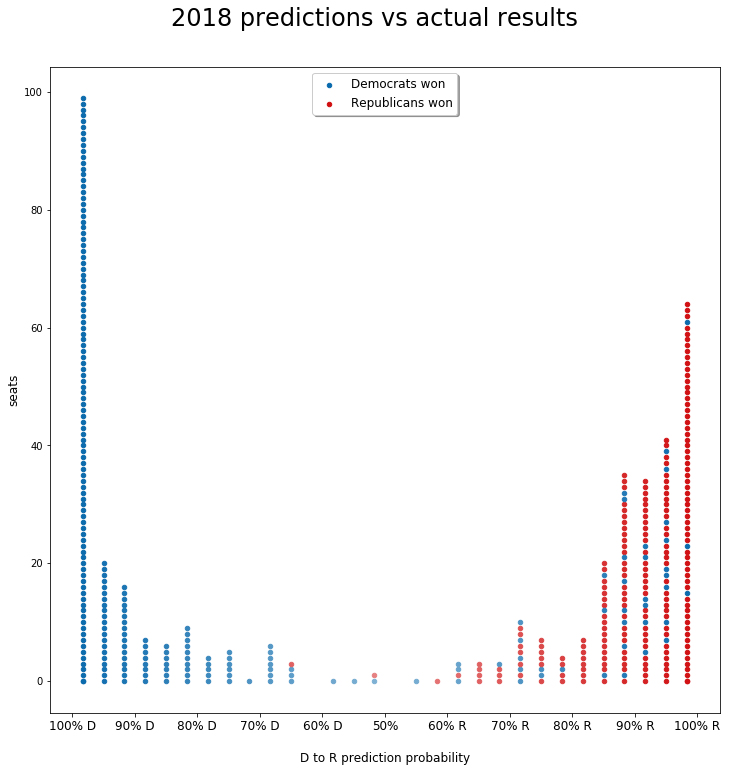

In [33]:
#plot predictions vs actual results
plotDR(pred2018)

<h2>Hyper-parameters tuning</h2>

In the next lines we have evaluated the parameters to use for decision trees, random forest and boosting

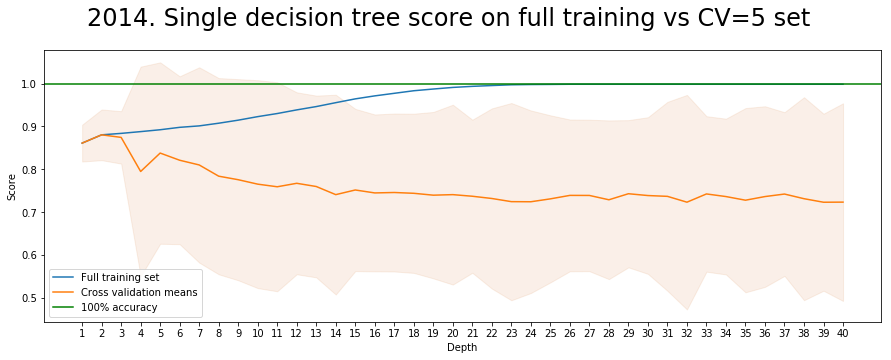

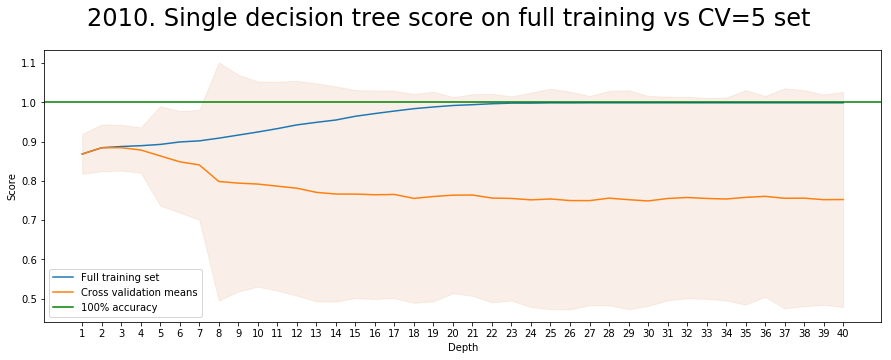

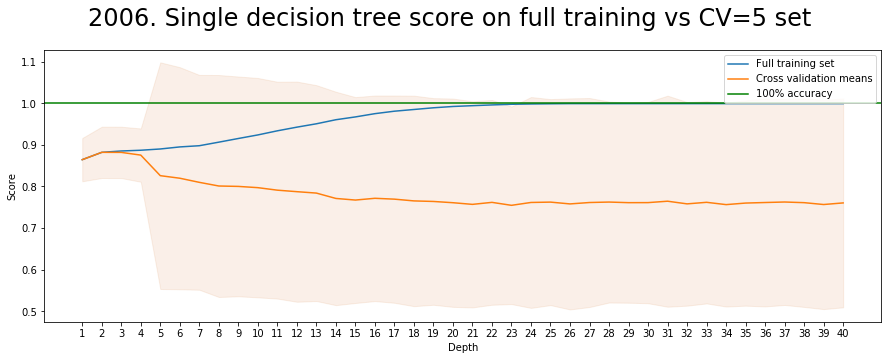

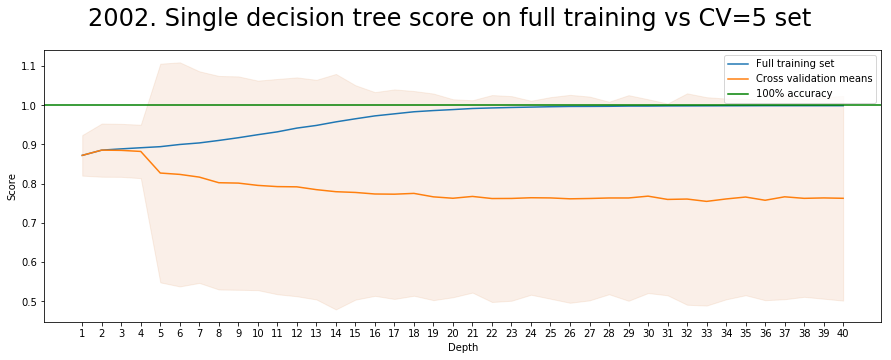

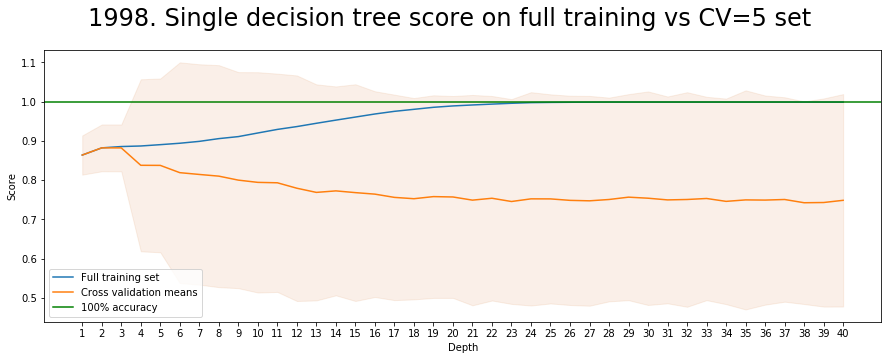

In [34]:
#find best depth for decision tree
years=Midterm_recent_years[:5]
for year in years:
#for year in []:
    #pre_process
    x_train_designFeatures, x_val_designFeatures, y_train, y_val, house_df_districts, house_df_party = pre_process(train_data, year)
            
    #fit model
    depths=list(range(1,41)) #set (maximum) tree depths 1, 2, 3, ..., 20
    scores_train = []
    scores_train_CV = []
    scores_train_CVstd = []
    for depth in depths:
        dt = DecisionTreeClassifier(max_depth = depth)
        scores = cross_val_score(estimator=dt, X=x_train_designFeatures, y=y_train, cv=5)
        scores_train_CV.append(scores.mean()) #cross-validated score
        scores_train_CVstd.append(scores.std()) #cross-validated score
        dt.fit(x_train_designFeatures, y_train)
        scores_train.append(dt.score(x_train_designFeatures, y_train)) #score on training data

    #plot
    title='{}. Single decision tree score on full training vs CV=5 set'.format(year)
    plotCVscores(depths, scores_train, scores_train_CV, scores_train_CVstd, title)  

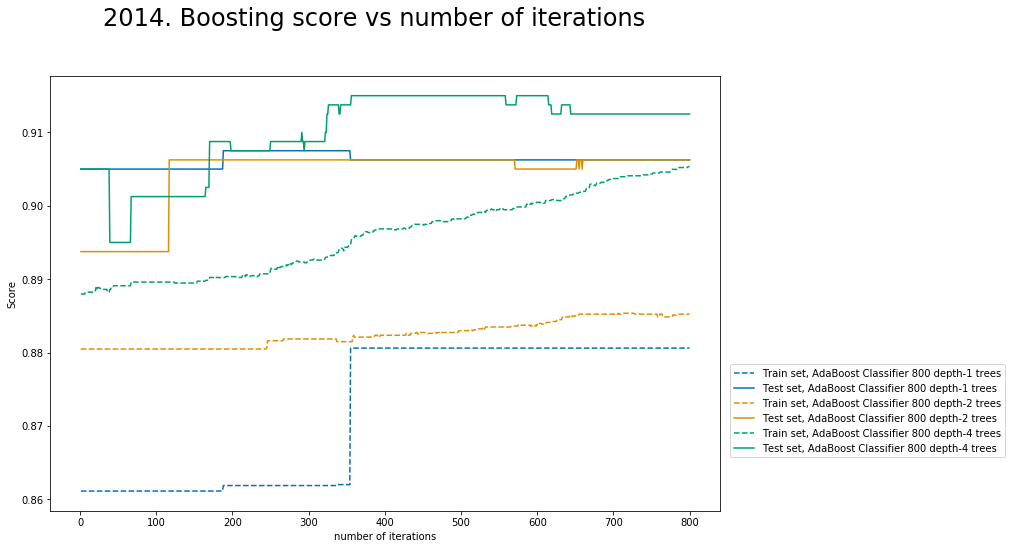

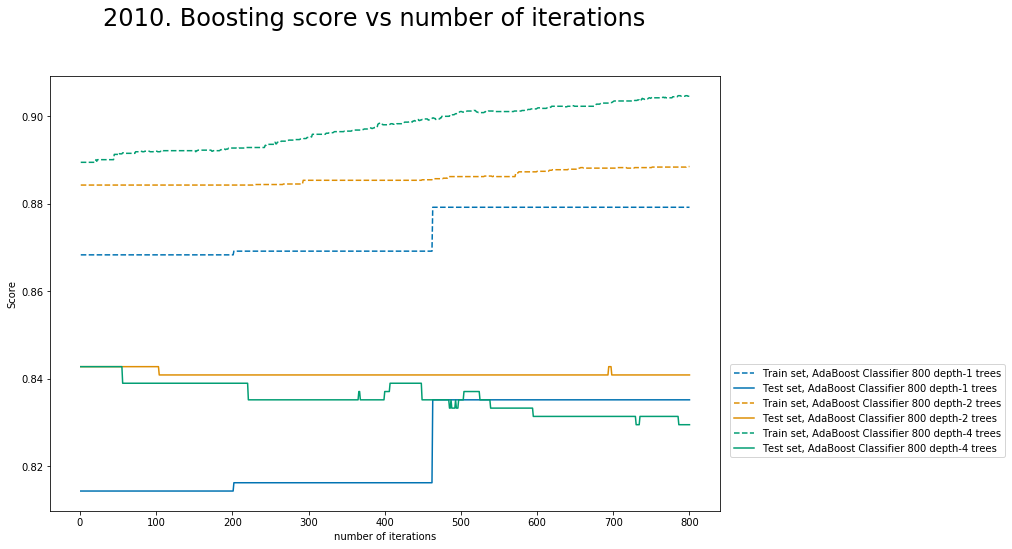

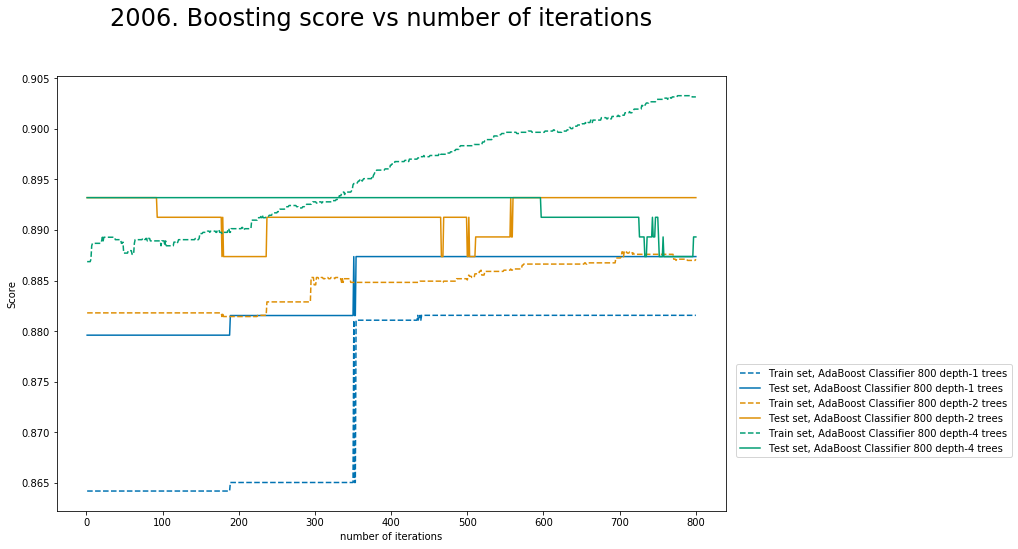

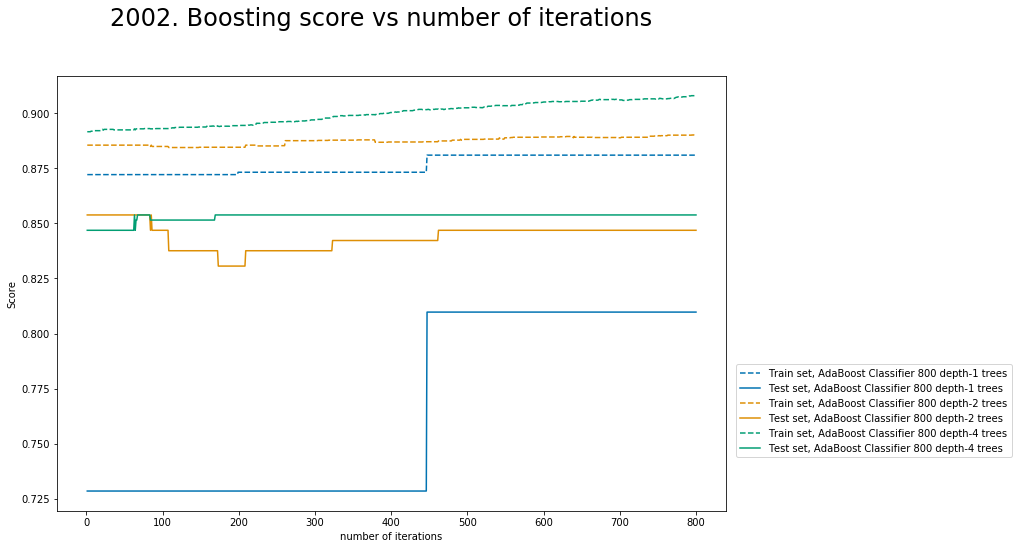

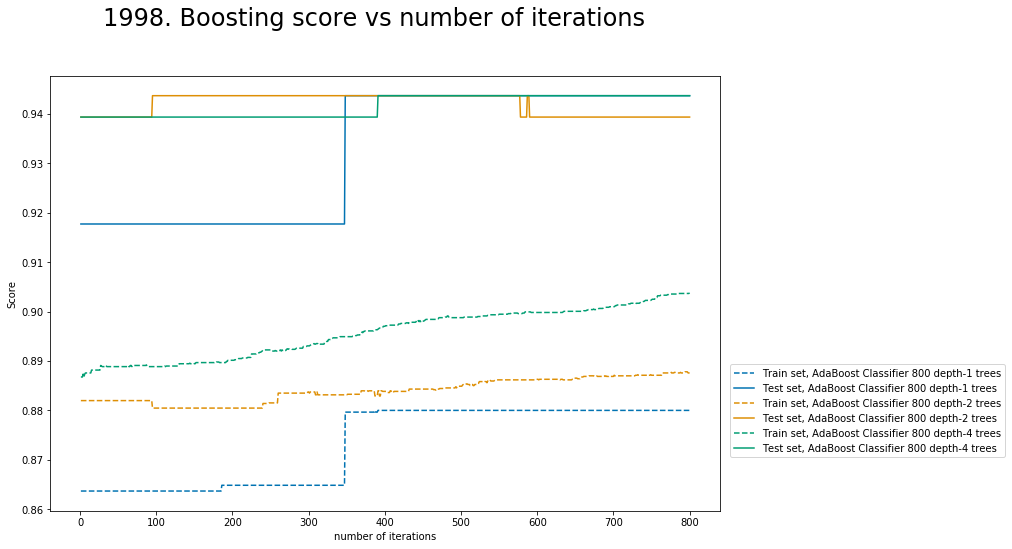

In [35]:
#find best depth for decision tree and best n_estimators
years=Midterm_recent_years[:5]
for year in years:
#for year in []:
    plotList=[]
    #pre_process
    x_train_designFeatures, x_val_designFeatures, y_train, y_val, house_df_districts, house_df_party = pre_process(train_data, year)
    
    #fit AdaBoost classifiers for tree depth = 1,2,4
    n_trees=800
    lrate=0.01
    for i in [1,2,4]:
        abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=i), n_estimators=n_trees, learning_rate=lrate)
        model=dict()
        model['name']='AdaBoost Classifier {} depth-{} trees'.format(n_trees, i)
        model['model']=abc.fit(x_train_designFeatures, y_train)
        model['training accuracy']=model['model'].score(x_train_designFeatures, y_train)
        model['test accuracy']=model['model'].score(x_val_designFeatures, y_val)
        plotList.append(model)
    title='{}. Boosting score vs number of iterations'.format(year)
    PlotAdaBoost3(plotList, x_train_designFeatures, y_train, x_val_designFeatures, y_val, title)